In [ ]:
# Final restart of my code
#notes:


seeded_run = False
prototyping = True
MLP_prototype = True
svm_prototype = True
XGB_prototype = True
RF_prototype = True
parameter_tuning = False
validation_runs = False
elliptic_dataset = True
IBM_dataset = False
#Select IBM dataset type/size
dataset_type_size = 'HISMALL'  # Options: 'HISMALL', 'HIMEDIUM', 'LISMALL', 'LIMEDIUM'
Full_run = True
num_epochs = 200
early_stop_patience = 60
early_stop_min_delta = 1e-4
early_stop_logging = True


#%% Quick functions

In [ ]:
# Detecting system
import platform
pc = platform.system()

import os
if pc == 'Darwin':
    os.chdir("/Users/lambertusvanzyl/Desktop/Final_serious")
else:
    os.chdir("/Users/Lambertus/Desktop/Final_serious")

#Setting seed
import torch
import numpy as np
if seeded_run == True:
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
else: 
    seed = np.random.SeedSequence().entropy
    
#Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx

from functools import partial

#Importing PyTorch libraries
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch import Tensor
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, GATConv, GINConv, global_add_pool
#import torch_geometric_temporal
#from torch_geometric_temporal.nn.recurrent import EvolveGCNH, EvolveGCNO

#Importing sklearn libraries
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import sys

In [ ]:
from Reading_files import readfiles
from pre_processing import elliptic_pre_processing, create_data_object, create_elliptic_masks
from debugging import print_tensor_info
from models import GCN, ModelWrapper, MLP
from training_functions import train_and_validate
from Helper_functions import FocalLoss, calculate_metrics, balanced_class_weights
from analysis import results_to_long_df, summarise_long_df, formatted_wide_table, produce_tables, boxplots_by_metric, bar_means_with_ci
from encoding import DGTEncoder

In [ ]:
from pre_processing import make_ibm_masks
if elliptic_dataset == True:
    features_df, classes_df, edgelist_df = readfiles(pc)
    features_df, classes_df, edgelist_df, known_nodes = elliptic_pre_processing(features_df, classes_df, edgelist_df)
    data = create_data_object(features_df, classes_df, edgelist_df)
    data = data.to('cuda' if torch.cuda.is_available() else 'cpu')

    train_mask, val_mask, test_mask, train_perf_eval, val_perf_eval, test_perf_eval = create_elliptic_masks(data)
    
if IBM_dataset == True:
    from stock_IBM_process import AMLtoGraph
    if pc =='Darwin':
        dataset = AMLtoGraph(root='/Users/lambertusvanzyl/Desktop/Final_serious/data', dataset_type_size=dataset_type_size)
        data: Data = dataset[0]
    else:
        dataset = AMLtoGraph(root='/Users/Lambertus/Desktop/Final_serious/data', dataset_type_size=dataset_type_size)
        data: Data = dataset[0]
    data = data.to('cuda' if torch.cuda.is_available() else 'cpu')
    
    data.y = data.y.long()
    
    train_mask, val_mask, test_mask, train_perf_eval, val_perf_eval, test_perf_eval = make_ibm_masks(data)

In [ ]:
# print_tensor_info(
#     train_mask=train_mask,
#     val_mask=val_mask,
#     test_mask=test_mask,
#     train_perf_eval=train_perf_eval,
#     val_perf_eval=val_perf_eval,
#     test_perf_eval=test_perf_eval
# )



#summarize_and_visualize_results(all_results)

In [ ]:
#variable for dataset used in optimization
if elliptic_dataset == True:
    data_for_optimization = 'elliptic'
elif IBM_dataset == True:
    if dataset_type_size == 'HISMALL':
        data_for_optimization = 'IBM_HISMALL'
    elif dataset_type_size == 'HIMEDIUM':
        data_for_optimization = 'IBM_HIMEDIUM'
    elif dataset_type_size == 'LISMALL':
        data_for_optimization = 'IBM_LISMALL'
    elif dataset_type_size == 'LIMEDIUM':
        data_for_optimization = 'IBM_LIMEDIUM'
        
        
if Full_run == True:
    from Testing import run_optimization

    model_parameters, testing_results = run_optimization(
                                                models=['XGB', 'RF','GCN', 'GAT', 'GIN', 'XGBe+GIN', 'GINe+XGB'],# 'XGB', 'RF','GCN', 'GAT', 'GIN', 'XGBe+GIN', 'GINe+XGB'    # Add or remove models as needed
                                                data=data,
                                                train_perf_eval=train_perf_eval,
                                                val_perf_eval=val_perf_eval,
                                                test_perf_eval=test_perf_eval,
                                                train_mask=train_mask,
                                                val_mask=val_mask,
                                                data_for_optimization=data_for_optimization
                                                )

#Save results from optimization
import pickle

def save_testing_results_pickle(results, path=f"testing_results_{data_for_optimization}.pkl"):
    with open(path, 'wb') as f:
        pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
        
save_testing_results_pickle(testing_results, "testing_results.pkl")

def save_testing_results_csv(results, path=f"{data_for_optimization}_testing_results.csv"):
    df = pd.DataFrame(results)
    df.to_csv(f"csv_results/{data_for_optimization}_testing_results.csv", index=False)

save_testing_results_csv(testing_results)

Models:   0%|          | 0/7 [00:00<?, ?model/s][I 2025-10-23 08:36:00,043] A new study created in RDB with name: XGB_optimization on elliptic dataset
[I 2025-10-23 08:36:03,374] Trial 0 finished with value: 0.7446728971962617 and parameters: {'hidden_units': 62, 'learning_rate': 0.0012522418518208626, 'weight_decay': 0.0001642617858355558, 'gamma_focal': 4.097070342629259, 'early_stop_patience': 22, 'early_stop_min_delta': 0.0011921543294526773, 'max_depth': 11, 'Gamma_XGB': 4.7682758699142695, 'n_estimators': 500}. Best is trial 0 with value: 0.7446728971962617.
[I 2025-10-23 08:36:04,497] Trial 1 finished with value: 0.1984562447689017 and parameters: {'hidden_units': 127, 'learning_rate': 0.00023709211004808466, 'weight_decay': 0.0002596157750503643, 'gamma_focal': 2.5772225123103674, 'early_stop_patience': 25, 'early_stop_min_delta': 0.004096318828912746, 'max_depth': 14, 'Gamma_XGB': 2.256965040919808, 'n_estimators': 100}. Best is trial 0 with value: 0.7446728971962617.
[I 2025-

Best hyperparameters for XGB: {'hidden_units': 62, 'learning_rate': 0.0049796117366862815, 'weight_decay': 0.00018146138868716611, 'gamma_focal': 2.0066525732621128, 'early_stop_patience': 12, 'early_stop_min_delta': 0.00035884027272659204, 'max_depth': 13, 'Gamma_XGB': 0.0067289017282657765, 'n_estimators': 500}


Models:  14%|█▍        | 1/7 [12:21<1:14:09, 741.57s/model][I 2025-10-23 08:48:21,053] A new study created in RDB with name: RF_optimization on elliptic dataset
[I 2025-10-23 08:48:30,696] Trial 0 finished with value: 0.9330746847720659 and parameters: {'hidden_units': 101, 'learning_rate': 0.003928597253499659, 'weight_decay': 0.001697893462857955, 'gamma_focal': 2.8845478290679614, 'early_stop_patience': 38, 'early_stop_min_delta': 0.00036961026864582264, 'n_estimators': 200, 'max_depth': 10}. Best is trial 0 with value: 0.9330746847720659.
[I 2025-10-23 08:48:33,296] Trial 1 finished with value: 0.9324915007285091 and parameters: {'hidden_units': 173, 'learning_rate': 8.394311963266865e-05, 'weight_decay': 0.0037359334717989513, 'gamma_focal': 2.32800977260319, 'early_stop_patience': 37, 'early_stop_min_delta': 0.0001229375213958784, 'n_estimators': 50, 'max_depth': 10}. Best is trial 0 with value: 0.9330746847720659.
[I 2025-10-23 08:48:45,847] Trial 2 finished with value: 0.937621

Best hyperparameters for RF: {'hidden_units': 215, 'learning_rate': 0.00031383015415698375, 'weight_decay': 0.001008892653505693, 'gamma_focal': 3.8294128966142544, 'early_stop_patience': 23, 'early_stop_min_delta': 0.0003087033241818824, 'n_estimators': 500, 'max_depth': 13}


Models:  29%|██▊       | 2/7 [1:42:36<4:50:52, 3490.44s/model][I 2025-10-23 10:18:35,663] A new study created in RDB with name: GCN_optimization on elliptic dataset
[I 2025-10-23 10:18:36,596] Trial 0 finished with value: 0.38095238095238093 and parameters: {'hidden_units': 69, 'learning_rate': 0.004617432182695766, 'weight_decay': 8.041842566728971e-05, 'gamma_focal': 3.9177275272507037, 'early_stop_patience': 9, 'early_stop_min_delta': 0.002983278453463795}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-10-23 10:18:37,996] Trial 1 finished with value: 0.3146211999356603 and parameters: {'hidden_units': 34, 'learning_rate': 0.0007527608520442858, 'weight_decay': 0.005184889294506013, 'gamma_focal': 3.092445748308623, 'early_stop_patience': 26, 'early_stop_min_delta': 0.0011859269905170938}. Best is trial 0 with value: 0.38095238095238093.
[I 2025-10-23 10:18:39,498] Trial 2 finished with value: 0.33786478158419436 and parameters: {'hidden_units': 51, 'learning_rate': 0.0008

Best hyperparameters for GCN: {'hidden_units': 240, 'learning_rate': 0.004035708130200405, 'weight_decay': 5.015373084304641e-05, 'gamma_focal': 2.8640510282552354, 'early_stop_patience': 25, 'early_stop_min_delta': 0.00018060971807400673}


Models:  43%|████▎     | 3/7 [1:49:18<2:18:41, 2080.25s/model][I 2025-10-23 10:25:17,814] A new study created in RDB with name: GAT_optimization on elliptic dataset
[I 2025-10-23 10:25:19,531] Trial 0 finished with value: 0.4496589358799454 and parameters: {'hidden_units': 132, 'learning_rate': 0.004880598095758815, 'weight_decay': 0.002259593045334638, 'gamma_focal': 3.1497845358516505, 'early_stop_patience': 24, 'early_stop_min_delta': 0.00039662386387142397, 'num_heads': 1}. Best is trial 0 with value: 0.4496589358799454.
[I 2025-10-23 10:25:21,862] Trial 1 finished with value: 0.38087617523504697 and parameters: {'hidden_units': 188, 'learning_rate': 0.002973217963711284, 'weight_decay': 0.0033495403762510896, 'gamma_focal': 2.083602974617914, 'early_stop_patience': 30, 'early_stop_min_delta': 0.00010063941219722176, 'num_heads': 4}. Best is trial 0 with value: 0.4496589358799454.
[I 2025-10-23 10:25:23,379] Trial 2 finished with value: 0.34320156000709096 and parameters: {'hidden_

Best hyperparameters for GAT: {'hidden_units': 201, 'learning_rate': 0.00443465176345336, 'weight_decay': 0.0005296008200565713, 'gamma_focal': 3.7692766848946495, 'early_stop_patience': 16, 'early_stop_min_delta': 0.0008118725294410297, 'num_heads': 1}


Models:  57%|█████▋    | 4/7 [1:55:44<1:10:34, 1411.45s/model][I 2025-10-23 10:31:43,980] A new study created in RDB with name: GIN_optimization on elliptic dataset
[I 2025-10-23 10:31:46,379] Trial 0 finished with value: 0.36309249884951683 and parameters: {'hidden_units': 144, 'learning_rate': 0.00010990496213219112, 'weight_decay': 0.002184651201691016, 'gamma_focal': 2.611404053877884, 'early_stop_patience': 30, 'early_stop_min_delta': 0.0039613808242574995}. Best is trial 0 with value: 0.36309249884951683.
[I 2025-10-23 10:31:48,812] Trial 1 finished with value: 0.3367388639149979 and parameters: {'hidden_units': 156, 'learning_rate': 0.00015790358447789448, 'weight_decay': 0.007143048100424034, 'gamma_focal': 4.3886922689693915, 'early_stop_patience': 12, 'early_stop_min_delta': 0.00025360400590786035}. Best is trial 0 with value: 0.36309249884951683.
[I 2025-10-23 10:31:53,806] Trial 2 finished with value: 0.48653395784543324 and parameters: {'hidden_units': 188, 'learning_rate'

Best hyperparameters for GIN: {'hidden_units': 242, 'learning_rate': 0.003615686441219359, 'weight_decay': 1.191842306277493e-05, 'gamma_focal': 3.3591909759123757, 'early_stop_patience': 38, 'early_stop_min_delta': 0.0006582806397174595}


Models:  71%|███████▏  | 5/7 [2:21:42<48:48, 1464.20s/model]  [I 2025-10-23 10:57:41,710] A new study created in RDB with name: XGBe+GIN_optimization on elliptic dataset


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 10:57:51,205] Trial 0 finished with value: 0.1984562447689017 and parameters: {'hidden_units': 43, 'learning_rate': 0.0007349168895148452, 'weight_decay': 0.0040214024105995755, 'gamma_focal': 4.552543500171823, 'early_stop_patience': 15, 'early_stop_min_delta': 0.0003151589504347179, 'xgbe_embedding_dim': 96, 'xgbe_n_estimators': 250, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.04119022330757562, 'xgbe_subsample': 0.6029636726597253, 'xgbe_colsample_bytree': 0.9880159553886501, 'xgbe_reg_lambda': 3.326565449500567, 'xgbe_reg_alpha': 0.028658749844761022, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.043069242796914466, 'gin_weight_decay': 0.007795683752117047}. Best is trial 0 with value: 0.1984562447689017.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 10:58:04,038] Trial 1 finished with value: 0.8141509433962263 and parameters: {'hidden_units': 201, 'learning_rate': 7.581746281173213e-05, 'weight_decay': 0.005197468876078902, 'gamma_focal': 2.816939354375995, 'early_stop_patience': 22, 'early_stop_min_delta': 0.000179255169283516, 'xgbe_embedding_dim': 96, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.11323568476889698, 'xgbe_subsample': 0.8809615658997747, 'xgbe_colsample_bytree': 0.9030734704930166, 'xgbe_reg_lambda': 0.8651491239645703, 'xgbe_reg_alpha': 4.987967942600015, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0483288627586049, 'gin_weight_decay': 2.4053068778928586e-06}. Best is trial 1 with value: 0.8141509433962263.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 10:58:26,634] Trial 2 finished with value: 0.8697696285848613 and parameters: {'hidden_units': 141, 'learning_rate': 0.0008574055444373066, 'weight_decay': 0.00026479096733184054, 'gamma_focal': 3.155650376397395, 'early_stop_patience': 36, 'early_stop_min_delta': 0.0001253061801929382, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 350, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.0029945713877334887, 'xgbe_subsample': 0.9547399039370372, 'xgbe_colsample_bytree': 0.9478044831799373, 'xgbe_reg_lambda': 2.746861923107372, 'xgbe_reg_alpha': 1.8739601258141036, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.003872455402585238, 'gin_weight_decay': 1.712792012086002e-06}. Best is trial 2 with value: 0.8697696285848613.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 10:58:40,458] Trial 3 finished with value: 0.8285960378983634 and parameters: {'hidden_units': 235, 'learning_rate': 0.0021149862010480113, 'weight_decay': 1.6669314533322726e-05, 'gamma_focal': 2.2744788233512705, 'early_stop_patience': 34, 'early_stop_min_delta': 0.00011014521039308586, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 350, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.08020917349541168, 'xgbe_subsample': 0.7738134736766209, 'xgbe_colsample_bytree': 0.5522221835563442, 'xgbe_reg_lambda': 2.5136746610489116, 'xgbe_reg_alpha': 0.26368275359496984, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.002532226199602002, 'gin_weight_decay': 0.00020921555756030295}. Best is trial 2 with value: 0.8697696285848613.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 10:58:59,621] Trial 4 finished with value: 0.6475445458496305 and parameters: {'hidden_units': 229, 'learning_rate': 5.25522575035048e-05, 'weight_decay': 0.005790130726522269, 'gamma_focal': 4.860912021426708, 'early_stop_patience': 31, 'early_stop_min_delta': 0.00019761902588878383, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.0013335659523862943, 'xgbe_subsample': 0.6348305251481352, 'xgbe_colsample_bytree': 0.6823378310482073, 'xgbe_reg_lambda': 4.0920632881682, 'xgbe_reg_alpha': 3.7988373543525626, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.046383716580241305, 'gin_weight_decay': 3.7802353332358694e-06}. Best is trial 2 with value: 0.8697696285848613.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 10:59:12,045] Trial 5 finished with value: 0.27930848190167473 and parameters: {'hidden_units': 125, 'learning_rate': 0.0010994137746815, 'weight_decay': 0.0026867136712907884, 'gamma_focal': 3.586148472742085, 'early_stop_patience': 10, 'early_stop_min_delta': 0.0006076778390074626, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 250, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.004532161988281601, 'xgbe_subsample': 0.6997722133178886, 'xgbe_colsample_bytree': 0.9737538841929841, 'xgbe_reg_lambda': 6.153292831396824, 'xgbe_reg_alpha': 4.773811724085876, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 64, 'gin_lr': 0.00040232951465517323, 'gin_weight_decay': 1.3919775616557581e-05}. Best is trial 2 with value: 0.8697696285848613.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 10:59:27,606] Trial 6 finished with value: 0.768236380424746 and parameters: {'hidden_units': 36, 'learning_rate': 0.002650715441898808, 'weight_decay': 0.0002311053866931703, 'gamma_focal': 3.245272756310402, 'early_stop_patience': 35, 'early_stop_min_delta': 0.0018674711483229356, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 250, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.06131199413215348, 'xgbe_subsample': 0.7503383156925894, 'xgbe_colsample_bytree': 0.724215143677263, 'xgbe_reg_lambda': 5.100687186574327, 'xgbe_reg_alpha': 1.8204879435665307, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.00048440300100520834, 'gin_weight_decay': 0.000134027614767219}. Best is trial 2 with value: 0.8697696285848613.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 10:59:37,291] Trial 7 finished with value: 0.01064773735581189 and parameters: {'hidden_units': 243, 'learning_rate': 0.0001413679463448757, 'weight_decay': 0.005261490586467308, 'gamma_focal': 2.533835168961598, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0003989403574837241, 'xgbe_embedding_dim': 64, 'xgbe_n_estimators': 300, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.0036214140232207637, 'xgbe_subsample': 0.7812656221488989, 'xgbe_colsample_bytree': 0.857634841934818, 'xgbe_reg_lambda': 9.543066319860051, 'xgbe_reg_alpha': 4.836239596857332, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.00029188814822210795, 'gin_weight_decay': 0.00791740700959693}. Best is trial 2 with value: 0.8697696285848613.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:00:10,124] Trial 8 finished with value: 0.8367924528301887 and parameters: {'hidden_units': 235, 'learning_rate': 6.168346234466417e-05, 'weight_decay': 1.3384633515891548e-05, 'gamma_focal': 2.507237663058039, 'early_stop_patience': 32, 'early_stop_min_delta': 0.0004288259025563055, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.0170083583645585, 'xgbe_subsample': 0.5403718455142636, 'xgbe_colsample_bytree': 0.7326713359975903, 'xgbe_reg_lambda': 7.553727609784621, 'xgbe_reg_alpha': 1.9705753337245557, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0011782456920378893, 'gin_weight_decay': 7.21971494940977e-05}. Best is trial 2 with value: 0.8697696285848613.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:00:16,053] Trial 9 finished with value: 0.6591107236268525 and parameters: {'hidden_units': 82, 'learning_rate': 0.0015829857012377368, 'weight_decay': 0.0002314075347293759, 'gamma_focal': 3.2096681559026954, 'early_stop_patience': 36, 'early_stop_min_delta': 0.00018279563721636523, 'xgbe_embedding_dim': 96, 'xgbe_n_estimators': 100, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.08696773880354196, 'xgbe_subsample': 0.6815612106231701, 'xgbe_colsample_bytree': 0.8726159247721827, 'xgbe_reg_lambda': 8.502941914526042, 'xgbe_reg_alpha': 3.5000423989858023, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0024200335843419666, 'gin_weight_decay': 0.0009776229888586376}. Best is trial 2 with value: 0.8697696285848613.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:00:26,427] Trial 10 finished with value: 0.8577960676726109 and parameters: {'hidden_units': 162, 'learning_rate': 0.00029735595220491216, 'weight_decay': 6.868897468533539e-05, 'gamma_focal': 4.064872983098914, 'early_stop_patience': 40, 'early_stop_min_delta': 0.00205863451917009, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 100, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.005976048222723116, 'xgbe_subsample': 0.9746815541245305, 'xgbe_colsample_bytree': 0.5015910460286619, 'xgbe_reg_lambda': 0.5260829810787224, 'xgbe_reg_alpha': 1.1155206982140573, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.007930175723089506, 'gin_weight_decay': 1.3251259849344421e-06}. Best is trial 2 with value: 0.8697696285848613.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:00:38,115] Trial 11 finished with value: 0.866067203028869 and parameters: {'hidden_units': 164, 'learning_rate': 0.0003004654660866707, 'weight_decay': 5.768558137454898e-05, 'gamma_focal': 4.078414859847779, 'early_stop_patience': 39, 'early_stop_min_delta': 0.004295659576338681, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 100, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.0054829824728431144, 'xgbe_subsample': 0.9944217393379945, 'xgbe_colsample_bytree': 0.502137409544015, 'xgbe_reg_lambda': 0.26250285120110495, 'xgbe_reg_alpha': 0.9720245199409758, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.009845293506696749, 'gin_weight_decay': 1.3912516386462127e-06}. Best is trial 2 with value: 0.8697696285848613.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:01:06,823] Trial 12 finished with value: 0.8359981726815898 and parameters: {'hidden_units': 158, 'learning_rate': 0.0003466038037034637, 'weight_decay': 0.0006621522314174117, 'gamma_focal': 3.9775705572345537, 'early_stop_patience': 27, 'early_stop_min_delta': 0.004769129356601807, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 7, 'xgbe_learning_rate': 0.0010783041363442414, 'xgbe_subsample': 0.9803066471570496, 'xgbe_colsample_bytree': 0.6368490350907433, 'xgbe_reg_lambda': 2.0864650514721905, 'xgbe_reg_alpha': 1.183505813032889, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.01033698181146039, 'gin_weight_decay': 8.971269078484006e-06}. Best is trial 2 with value: 0.8697696285848613.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:01:21,504] Trial 13 finished with value: 0.8829005389514943 and parameters: {'hidden_units': 126, 'learning_rate': 0.0005148326066018672, 'weight_decay': 6.338670747542134e-05, 'gamma_focal': 3.9886067985944718, 'early_stop_patience': 40, 'early_stop_min_delta': 0.0012085240192091504, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 150, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.010735348202586521, 'xgbe_subsample': 0.8798957320829984, 'xgbe_colsample_bytree': 0.7815034825222152, 'xgbe_reg_lambda': 0.1445541179312257, 'xgbe_reg_alpha': 2.7685642405662243, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.007784439398052061, 'gin_weight_decay': 1.0072074744286079e-06}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:01:40,386] Trial 14 finished with value: 0.7509541984732825 and parameters: {'hidden_units': 122, 'learning_rate': 0.0006705147860435288, 'weight_decay': 0.0006943092453862625, 'gamma_focal': 3.7286625968834706, 'early_stop_patience': 26, 'early_stop_min_delta': 0.0012195291487726483, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.014738819043123748, 'xgbe_subsample': 0.8737380487822421, 'xgbe_colsample_bytree': 0.8087318688421987, 'xgbe_reg_lambda': 1.8904608113580124, 'xgbe_reg_alpha': 2.9240204345379115, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.006137204330273804, 'gin_weight_decay': 1.823605301332274e-05}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:01:51,597] Trial 15 finished with value: 0.7904092600248036 and parameters: {'hidden_units': 82, 'learning_rate': 0.00017974382780953623, 'weight_decay': 7.320507826543087e-05, 'gamma_focal': 3.0838318907949374, 'early_stop_patience': 40, 'early_stop_min_delta': 0.001123465079070754, 'xgbe_embedding_dim': 64, 'xgbe_n_estimators': 200, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.002316448146197099, 'xgbe_subsample': 0.8696312712786807, 'xgbe_colsample_bytree': 0.7973523972519648, 'xgbe_reg_lambda': 4.269972098521664, 'xgbe_reg_alpha': 2.8205693465469874, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.020377889094448057, 'gin_weight_decay': 5.115334773789314e-06}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:02:03,765] Trial 16 finished with value: 0.5831202046035805 and parameters: {'hidden_units': 189, 'learning_rate': 0.001085775602532167, 'weight_decay': 3.6517787819052314e-05, 'gamma_focal': 4.358992196232438, 'early_stop_patience': 28, 'early_stop_min_delta': 0.0008065718734002078, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 200, 'xgbe_max_depth': 7, 'xgbe_learning_rate': 0.028849425434775033, 'xgbe_subsample': 0.9261364061848008, 'xgbe_colsample_bytree': 0.9376790582651481, 'xgbe_reg_lambda': 1.2768738545964275, 'xgbe_reg_alpha': 2.160087139484134, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.00012357259367559408, 'gin_weight_decay': 3.0661663326086865e-05}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:02:21,033] Trial 17 finished with value: 0.7931382441977801 and parameters: {'hidden_units': 98, 'learning_rate': 0.0004931273442596828, 'weight_decay': 0.00014531135511374155, 'gamma_focal': 2.06318125817596, 'early_stop_patience': 22, 'early_stop_min_delta': 0.002275281089063735, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.008647916223468815, 'xgbe_subsample': 0.8231875560528051, 'xgbe_colsample_bytree': 0.8013232199827945, 'xgbe_reg_lambda': 3.089625261940273, 'xgbe_reg_alpha': 3.4915665176355133, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.004067330105765466, 'gin_weight_decay': 1.0436233925713328e-06}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:02:28,940] Trial 18 finished with value: 0.5585365853658537 and parameters: {'hidden_units': 135, 'learning_rate': 0.004710047254042555, 'weight_decay': 0.00076956883222487, 'gamma_focal': 3.4457755498164024, 'early_stop_patience': 6, 'early_stop_min_delta': 0.0006544893492246442, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 150, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.0022938706492768085, 'xgbe_subsample': 0.9139970650672922, 'xgbe_colsample_bytree': 0.618504562528512, 'xgbe_reg_lambda': 5.635742699365156, 'xgbe_reg_alpha': 2.518148760669127, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.0011176944600646604, 'gin_weight_decay': 4.580682074875299e-05}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:02:50,163] Trial 19 finished with value: 0.867906976744186 and parameters: {'hidden_units': 105, 'learning_rate': 0.0005276130493378692, 'weight_decay': 0.001531996013634564, 'gamma_focal': 2.9088381523760183, 'early_stop_patience': 36, 'early_stop_min_delta': 0.001246463121818963, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 350, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.010704717704267362, 'xgbe_subsample': 0.8312954948932789, 'xgbe_colsample_bytree': 0.8457279037966416, 'xgbe_reg_lambda': 1.6308329547060665, 'xgbe_reg_alpha': 4.258202562357682, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.018422446988995717, 'gin_weight_decay': 6.007984854706238e-06}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:03:06,836] Trial 20 finished with value: 0.7189835575485799 and parameters: {'hidden_units': 191, 'learning_rate': 0.00013172137630780293, 'weight_decay': 2.9724334259718488e-05, 'gamma_focal': 4.434403489475093, 'early_stop_patience': 30, 'early_stop_min_delta': 0.00010249506313654296, 'xgbe_embedding_dim': 64, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.024016891003570257, 'xgbe_subsample': 0.9354711502445113, 'xgbe_colsample_bytree': 0.922700773413212, 'xgbe_reg_lambda': 0.23592280017619993, 'xgbe_reg_alpha': 1.653012153897167, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0011563212276278969, 'gin_weight_decay': 0.0006119674679139932}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:03:25,122] Trial 21 finished with value: 0.8259717314487631 and parameters: {'hidden_units': 104, 'learning_rate': 0.0004854770535936379, 'weight_decay': 0.0004234103320416957, 'gamma_focal': 2.8433699027535893, 'early_stop_patience': 37, 'early_stop_min_delta': 0.0014934032875862104, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 350, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.009554367928562674, 'xgbe_subsample': 0.8332350446577288, 'xgbe_colsample_bytree': 0.8340340659461428, 'xgbe_reg_lambda': 1.4190566286966835, 'xgbe_reg_alpha': 4.200921614826152, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.018589695815136333, 'gin_weight_decay': 5.607785429337421e-06}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:03:41,688] Trial 22 finished with value: 0.7485549132947977 and parameters: {'hidden_units': 62, 'learning_rate': 0.0009072010800339612, 'weight_decay': 0.001624036856590722, 'gamma_focal': 2.925558049354954, 'early_stop_patience': 37, 'early_stop_min_delta': 0.00299074920365931, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 300, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.010484224197327675, 'xgbe_subsample': 0.8178749820235518, 'xgbe_colsample_bytree': 0.7660401457858653, 'xgbe_reg_lambda': 3.0270703833984736, 'xgbe_reg_alpha': 4.209012706076866, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.017675816768081914, 'gin_weight_decay': 2.6955737129461117e-06}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:04:01,712] Trial 23 finished with value: 0.8814192343604107 and parameters: {'hidden_units': 108, 'learning_rate': 0.00044171704415228567, 'weight_decay': 0.0001294545148654813, 'gamma_focal': 3.7961714253372216, 'early_stop_patience': 33, 'early_stop_min_delta': 0.0007831543411036886, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.17285979498926343, 'xgbe_subsample': 0.9415782761300263, 'xgbe_colsample_bytree': 0.8844860601835568, 'xgbe_reg_lambda': 1.445154174696652, 'xgbe_reg_alpha': 3.0969676752296733, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.005345138831798155, 'gin_weight_decay': 2.433974928481578e-06}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:04:24,898] Trial 24 finished with value: 0.873981792045999 and parameters: {'hidden_units': 146, 'learning_rate': 0.00019597159241347561, 'weight_decay': 0.00012504832571313314, 'gamma_focal': 3.910800555107939, 'early_stop_patience': 33, 'early_stop_min_delta': 0.0008550298214770154, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.0030082394468949752, 'xgbe_subsample': 0.9470425758758418, 'xgbe_colsample_bytree': 0.9540443282415839, 'xgbe_reg_lambda': 3.7649135284762147, 'xgbe_reg_alpha': 2.9416869296930974, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.004105282814391797, 'gin_weight_decay': 2.116635363382776e-06}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:04:46,578] Trial 25 finished with value: 0.8560712611345522 and parameters: {'hidden_units': 117, 'learning_rate': 0.0001909509595346521, 'weight_decay': 0.00011765988376381338, 'gamma_focal': 3.832890805719789, 'early_stop_patience': 33, 'early_stop_min_delta': 0.0008415257003026133, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.17882441441517433, 'xgbe_subsample': 0.9065685106937088, 'xgbe_colsample_bytree': 0.8948210750858961, 'xgbe_reg_lambda': 4.430100145250263, 'xgbe_reg_alpha': 2.9111710807951674, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.004763792973354644, 'gin_weight_decay': 1.1161114825621808e-05}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:05:09,652] Trial 26 finished with value: 0.8631195998180992 and parameters: {'hidden_units': 151, 'learning_rate': 0.00022957293848407874, 'weight_decay': 0.00012572653521110113, 'gamma_focal': 4.25122788825634, 'early_stop_patience': 25, 'early_stop_min_delta': 0.0005280900965267569, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.04096068170776144, 'xgbe_subsample': 0.9416314710412681, 'xgbe_colsample_bytree': 0.9964166777528839, 'xgbe_reg_lambda': 0.9606417839599593, 'xgbe_reg_alpha': 3.276410470852851, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.0019116864841431532, 'gin_weight_decay': 2.741459616843059e-06}. Best is trial 13 with value: 0.8829005389514943.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:05:34,591] Trial 27 finished with value: 0.8886783514921839 and parameters: {'hidden_units': 173, 'learning_rate': 0.00010954339128896548, 'weight_decay': 2.5509273828849975e-05, 'gamma_focal': 3.5221635213473075, 'early_stop_patience': 19, 'early_stop_min_delta': 0.0009198756714754435, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.19321539480080344, 'xgbe_subsample': 0.8925204775563902, 'xgbe_colsample_bytree': 0.7587028137222639, 'xgbe_reg_lambda': 6.238602997934954, 'xgbe_reg_alpha': 2.4009896664081096, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.01105387086503882, 'gin_weight_decay': 2.104557636092487e-05}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:05:55,692] Trial 28 finished with value: 0.8390287769784172 and parameters: {'hidden_units': 213, 'learning_rate': 0.00010026649643995646, 'weight_decay': 2.3908206912949606e-05, 'gamma_focal': 3.519885128718467, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0010348390058799982, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.1993729072331556, 'xgbe_subsample': 0.8813490925424134, 'xgbe_colsample_bytree': 0.6952981740761002, 'xgbe_reg_lambda': 6.139149284677992, 'xgbe_reg_alpha': 2.454635111401553, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.013161699322415283, 'gin_weight_decay': 2.6518752729269102e-05}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:06:09,744] Trial 29 finished with value: 0.2697193037478438 and parameters: {'hidden_units': 178, 'learning_rate': 9.50647002288592e-05, 'weight_decay': 4.190155223422579e-05, 'gamma_focal': 4.712620964224481, 'early_stop_patience': 15, 'early_stop_min_delta': 0.00026942764185523534, 'xgbe_embedding_dim': 96, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.1335767417904756, 'xgbe_subsample': 0.5124322703754756, 'xgbe_colsample_bytree': 0.7682526316478527, 'xgbe_reg_lambda': 7.311834099894337, 'xgbe_reg_alpha': 2.2840841818060764, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.007041709627751785, 'gin_weight_decay': 0.003221867409243262}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:06:24,635] Trial 30 finished with value: 0.8468634686346864 and parameters: {'hidden_units': 61, 'learning_rate': 0.00034950138242331627, 'weight_decay': 1.80455557533306e-05, 'gamma_focal': 3.703953473181956, 'early_stop_patience': 18, 'early_stop_min_delta': 0.002882131741552665, 'xgbe_embedding_dim': 64, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.0516357807285143, 'xgbe_subsample': 0.8533316935585742, 'xgbe_colsample_bytree': 0.6873882453238049, 'xgbe_reg_lambda': 6.766605715571177, 'xgbe_reg_alpha': 1.5303727720607667, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.02671868634196456, 'gin_weight_decay': 8.772151700843832e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:06:43,736] Trial 31 finished with value: 0.852928028609745 and parameters: {'hidden_units': 141, 'learning_rate': 0.00023223566803659668, 'weight_decay': 9.155665729016446e-05, 'gamma_focal': 3.863326305893839, 'early_stop_patience': 24, 'early_stop_min_delta': 0.0008652905646874255, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.13766958811695812, 'xgbe_subsample': 0.899248120556471, 'xgbe_colsample_bytree': 0.9670159095217039, 'xgbe_reg_lambda': 3.7797921449579905, 'xgbe_reg_alpha': 2.6732350841874073, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.0037488593930103853, 'gin_weight_decay': 2.247343957402994e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:07:05,086] Trial 32 finished with value: 0.8360343183984746 and parameters: {'hidden_units': 174, 'learning_rate': 0.00011247799980125521, 'weight_decay': 4.5084319482885274e-05, 'gamma_focal': 3.4130018562173694, 'early_stop_patience': 30, 'early_stop_min_delta': 0.0015570856677827912, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.024000161293668255, 'xgbe_subsample': 0.9613740527024593, 'xgbe_colsample_bytree': 0.8910201723789103, 'xgbe_reg_lambda': 4.938512402835534, 'xgbe_reg_alpha': 2.927290348854876, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.00562002576664706, 'gin_weight_decay': 1.1072173084602293e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:07:28,344] Trial 33 finished with value: 0.8771106941838649 and parameters: {'hidden_units': 132, 'learning_rate': 0.0006328642204301786, 'weight_decay': 1.0564643815567015e-05, 'gamma_focal': 4.180673713735606, 'early_stop_patience': 20, 'early_stop_min_delta': 0.0004139039041260143, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.09236754839959994, 'xgbe_subsample': 0.9985407761805717, 'xgbe_colsample_bytree': 0.8221383426615768, 'xgbe_reg_lambda': 0.014348878395994219, 'xgbe_reg_alpha': 3.1738329525103004, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.03318834206281082, 'gin_weight_decay': 3.5318872322827356e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:07:44,038] Trial 34 finished with value: 0.8075471698113208 and parameters: {'hidden_units': 130, 'learning_rate': 0.0006842220396404177, 'weight_decay': 1.0221516176585652e-05, 'gamma_focal': 4.24642273910385, 'early_stop_patience': 21, 'early_stop_min_delta': 0.0003175253662456185, 'xgbe_embedding_dim': 96, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.08935646060370786, 'xgbe_subsample': 0.986693983037818, 'xgbe_colsample_bytree': 0.8234392230877441, 'xgbe_reg_lambda': 0.08115986187993089, 'xgbe_reg_alpha': 3.2886278622074068, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.03614625597343082, 'gin_weight_decay': 3.928487042990681e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:07:59,023] Trial 35 finished with value: 0.587719298245614 and parameters: {'hidden_units': 89, 'learning_rate': 0.0004294425569119046, 'weight_decay': 2.384563714823227e-05, 'gamma_focal': 4.559526583188353, 'early_stop_patience': 11, 'early_stop_min_delta': 0.00042670814369181147, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.10619591999249214, 'xgbe_subsample': 0.7880026240379521, 'xgbe_colsample_bytree': 0.7698236243805144, 'xgbe_reg_lambda': 0.6441508295688828, 'xgbe_reg_alpha': 3.854195740983543, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.03149829272930045, 'gin_weight_decay': 7.793556801165382e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:08:18,931] Trial 36 finished with value: 0.8402810304449647 and parameters: {'hidden_units': 113, 'learning_rate': 0.0012994983021086598, 'weight_decay': 1.63824703867738e-05, 'gamma_focal': 3.686535999172867, 'early_stop_patience': 15, 'early_stop_min_delta': 0.0005322998565032722, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.15009096354230975, 'xgbe_subsample': 0.9984718166826888, 'xgbe_colsample_bytree': 0.740631345334006, 'xgbe_reg_lambda': 2.1538853205797, 'xgbe_reg_alpha': 3.241498765852273, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.012927876045232744, 'gin_weight_decay': 1.7687897393424136e-05}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:08:46,302] Trial 37 finished with value: 0.8858360966366651 and parameters: {'hidden_units': 211, 'learning_rate': 0.0020999930650831486, 'weight_decay': 1.0668360206141705e-05, 'gamma_focal': 4.176195252992686, 'early_stop_patience': 20, 'early_stop_min_delta': 0.00025648280775512704, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.06483910848163858, 'xgbe_subsample': 0.9031198650410515, 'xgbe_colsample_bytree': 0.8700154600558151, 'xgbe_reg_lambda': 0.972202077360123, 'xgbe_reg_alpha': 3.8040509711480963, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.027363154346324796, 'gin_weight_decay': 3.7479317460459637e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:09:05,485] Trial 38 finished with value: 0.8286995515695067 and parameters: {'hidden_units': 221, 'learning_rate': 0.0027032939728266784, 'weight_decay': 2.4877937287216678e-05, 'gamma_focal': 4.531868094256335, 'early_stop_patience': 12, 'early_stop_min_delta': 0.00013135191832170788, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.06118467039762924, 'xgbe_subsample': 0.721410383854417, 'xgbe_colsample_bytree': 0.914952235251721, 'xgbe_reg_lambda': 1.0136967704558166, 'xgbe_reg_alpha': 3.742049873466278, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.011661871782157928, 'gin_weight_decay': 6.876716643360677e-05}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:09:24,219] Trial 39 finished with value: 0.8005952380952381 and parameters: {'hidden_units': 205, 'learning_rate': 0.0046958214877156935, 'weight_decay': 4.796893027062621e-05, 'gamma_focal': 3.581172087526402, 'early_stop_patience': 24, 'early_stop_min_delta': 0.00024257126654137533, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 300, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.032208361437621104, 'xgbe_subsample': 0.8017386634768706, 'xgbe_colsample_bytree': 0.8583925697967041, 'xgbe_reg_lambda': 2.679246714111749, 'xgbe_reg_alpha': 4.434395599649376, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.003050992605945284, 'gin_weight_decay': 1.6692116820760871e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:09:37,247] Trial 40 finished with value: 0.6904761904761906 and parameters: {'hidden_units': 197, 'learning_rate': 0.002058212077408037, 'weight_decay': 0.0001891915432538804, 'gamma_focal': 4.944407876061658, 'early_stop_patience': 20, 'early_stop_min_delta': 0.0015320760153295573, 'xgbe_embedding_dim': 96, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.07208723249662313, 'xgbe_subsample': 0.8897862133895934, 'xgbe_colsample_bytree': 0.7122880020175647, 'xgbe_reg_lambda': 2.397401019101516, 'xgbe_reg_alpha': 3.8600324425118338, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.0492680375057708, 'gin_weight_decay': 2.7695579096723508e-05}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:10:02,090] Trial 41 finished with value: 0.8460803059273424 and parameters: {'hidden_units': 131, 'learning_rate': 0.0008160186324465368, 'weight_decay': 1.1345844310527345e-05, 'gamma_focal': 4.140841624949949, 'early_stop_patience': 19, 'early_stop_min_delta': 0.00032038435005870555, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.1092917121658396, 'xgbe_subsample': 0.958028324468942, 'xgbe_colsample_bytree': 0.8811621972450356, 'xgbe_reg_lambda': 0.9419810101547568, 'xgbe_reg_alpha': 3.57816565378789, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.02579212868979125, 'gin_weight_decay': 3.536352712996556e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:10:23,751] Trial 42 finished with value: 0.849793293523197 and parameters: {'hidden_units': 251, 'learning_rate': 7.394730205993582e-05, 'weight_decay': 1.6842521546618375e-05, 'gamma_focal': 4.219594937795353, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0005366670062946037, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.16609585368490207, 'xgbe_subsample': 0.8546594377359676, 'xgbe_colsample_bytree': 0.7859957231466277, 'xgbe_reg_lambda': 0.08378631853228602, 'xgbe_reg_alpha': 3.1510143904583092, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.007885279829113492, 'gin_weight_decay': 0.00016456528840447414}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:10:45,125] Trial 43 finished with value: 0.8272157564905999 and parameters: {'hidden_units': 178, 'learning_rate': 0.00335730022331766, 'weight_decay': 0.00904150982962799, 'gamma_focal': 3.9842767591252453, 'early_stop_patience': 23, 'early_stop_min_delta': 0.00022312176169306987, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.11067353939841788, 'xgbe_subsample': 0.9243031507188687, 'xgbe_colsample_bytree': 0.8190165510513306, 'xgbe_reg_lambda': 1.5747434994215515, 'xgbe_reg_alpha': 2.641955657979721, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.037597356315119346, 'gin_weight_decay': 3.7930765057491697e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:11:07,446] Trial 44 finished with value: 0.8677098150782362 and parameters: {'hidden_units': 154, 'learning_rate': 0.0014959461100431907, 'weight_decay': 1.4298720583209002e-05, 'gamma_focal': 3.4073822424902835, 'early_stop_patience': 13, 'early_stop_min_delta': 0.00015688997530029333, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.05262126031923593, 'xgbe_subsample': 0.9690344245895255, 'xgbe_colsample_bytree': 0.6606763644881719, 'xgbe_reg_lambda': 0.6091646872277446, 'xgbe_reg_alpha': 2.1560630187282683, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.014649893413876326, 'gin_weight_decay': 1.991912794289603e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:11:31,941] Trial 45 finished with value: 0.810836961780358 and parameters: {'hidden_units': 140, 'learning_rate': 0.0010089383179470441, 'weight_decay': 2.9687239284249623e-05, 'gamma_focal': 4.690327546364847, 'early_stop_patience': 16, 'early_stop_min_delta': 0.00038679842653937293, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.07492572825647685, 'xgbe_subsample': 0.6438479729347448, 'xgbe_colsample_bytree': 0.7548630567252268, 'xgbe_reg_lambda': 6.841265801939569, 'xgbe_reg_alpha': 0.4495384606529984, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.026840955378165877, 'gin_weight_decay': 1.008735871492004e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:11:39,436] Trial 46 finished with value: 0.546452084857352 and parameters: {'hidden_units': 164, 'learning_rate': 0.0006037122669490096, 'weight_decay': 1.0143361698312817e-05, 'gamma_focal': 3.8010436561159375, 'early_stop_patience': 20, 'early_stop_min_delta': 0.0006915563190769975, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 200, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.137577849473725, 'xgbe_subsample': 0.8495944976782961, 'xgbe_colsample_bytree': 0.861861942441788, 'xgbe_reg_lambda': 8.843502528942823, 'xgbe_reg_alpha': 2.3798662936062, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.008571237693395498, 'gin_weight_decay': 0.0003609605119105864}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:11:47,371] Trial 47 finished with value: 0.7714410100130605 and parameters: {'hidden_units': 66, 'learning_rate': 0.001886441564091446, 'weight_decay': 0.0003518233176460552, 'gamma_focal': 4.0849037899454155, 'early_stop_patience': 8, 'early_stop_min_delta': 0.0010011602307787098, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 150, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.019323614158738095, 'xgbe_subsample': 0.9053707024704576, 'xgbe_colsample_bytree': 0.8362499493123876, 'xgbe_reg_lambda': 0.00759971536875792, 'xgbe_reg_alpha': 3.1711750482837826, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 64, 'gin_lr': 0.02407412594351128, 'gin_weight_decay': 1.1978624278283725e-05}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:12:09,406] Trial 48 finished with value: 0.7963839862247094 and parameters: {'hidden_units': 113, 'learning_rate': 0.00038112906295393565, 'weight_decay': 7.063328287214445e-05, 'gamma_focal': 3.294371593085863, 'early_stop_patience': 28, 'early_stop_min_delta': 0.00046551180958865387, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.006879668782880952, 'xgbe_subsample': 0.7453473621800312, 'xgbe_colsample_bytree': 0.7201261640499619, 'xgbe_reg_lambda': 1.1837879485406682, 'xgbe_reg_alpha': 1.9939948191652384, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.0017011963715059817, 'gin_weight_decay': 5.7654451624951475e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:12:18,913] Trial 49 finished with value: 0.8135742617893346 and parameters: {'hidden_units': 92, 'learning_rate': 0.00026904387764274364, 'weight_decay': 2.012140705361079e-05, 'gamma_focal': 4.353094298907883, 'early_stop_patience': 38, 'early_stop_min_delta': 0.00035860273872907067, 'xgbe_embedding_dim': 64, 'xgbe_n_estimators': 250, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.04060603523699406, 'xgbe_subsample': 0.5751269261626384, 'xgbe_colsample_bytree': 0.7813077454083786, 'xgbe_reg_lambda': 0.5335232367295255, 'xgbe_reg_alpha': 3.53949075528839, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.005657379295635507, 'gin_weight_decay': 1.58758316293927e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:12:39,525] Trial 50 finished with value: 0.860036832412523 and parameters: {'hidden_units': 170, 'learning_rate': 0.0013408935269984318, 'weight_decay': 3.178315219019824e-05, 'gamma_focal': 4.003844634424641, 'early_stop_patience': 21, 'early_stop_min_delta': 0.0006057006447741552, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.09860858096743028, 'xgbe_subsample': 0.9330241814179066, 'xgbe_colsample_bytree': 0.9093343817884457, 'xgbe_reg_lambda': 1.801613115719058, 'xgbe_reg_alpha': 2.637604822866339, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.009461727228157562, 'gin_weight_decay': 4.215307477468432e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:12:59,729] Trial 51 finished with value: 0.864462040055892 and parameters: {'hidden_units': 149, 'learning_rate': 0.00015269619912472625, 'weight_decay': 0.0001804921893337653, 'gamma_focal': 3.9086407597018566, 'early_stop_patience': 33, 'early_stop_min_delta': 0.0007746168637079995, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.12277496534833504, 'xgbe_subsample': 0.9484626144155548, 'xgbe_colsample_bytree': 0.943247825310409, 'xgbe_reg_lambda': 3.7690069650263824, 'xgbe_reg_alpha': 3.0483235691489545, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.0035893521573492062, 'gin_weight_decay': 2.026372052161959e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:13:19,699] Trial 52 finished with value: 0.8125552608311228 and parameters: {'hidden_units': 124, 'learning_rate': 6.698513486747448e-05, 'weight_decay': 9.894647102532714e-05, 'gamma_focal': 3.6298918282840194, 'early_stop_patience': 31, 'early_stop_min_delta': 0.001307695409653879, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.0018956110665819153, 'xgbe_subsample': 0.9726842255273809, 'xgbe_colsample_bytree': 0.9768132090151395, 'xgbe_reg_lambda': 6.002175996898133, 'xgbe_reg_alpha': 2.755644522817405, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.014614018019491274, 'gin_weight_decay': 2.628864561644368e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:13:42,998] Trial 53 finished with value: 0.8738695859114708 and parameters: {'hidden_units': 144, 'learning_rate': 5.451131309012159e-05, 'weight_decay': 8.939999911914129e-05, 'gamma_focal': 4.15212215530613, 'early_stop_patience': 34, 'early_stop_min_delta': 0.0009830752543382893, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.0036524855851944637, 'xgbe_subsample': 0.9521878216504517, 'xgbe_colsample_bytree': 0.9634566482084741, 'xgbe_reg_lambda': 5.087977719718193, 'xgbe_reg_alpha': 4.008759667723202, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.0026066655584572216, 'gin_weight_decay': 1.6380819777750095e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:14:05,712] Trial 54 finished with value: 0.8547328959700093 and parameters: {'hidden_units': 185, 'learning_rate': 0.00019127919763478894, 'weight_decay': 1.3193838053841627e-05, 'gamma_focal': 3.813422461100976, 'early_stop_patience': 39, 'early_stop_min_delta': 0.001838782085114959, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.004255100746914855, 'xgbe_subsample': 0.9208532729947299, 'xgbe_colsample_bytree': 0.8734806284205873, 'xgbe_reg_lambda': 8.185747066741985, 'xgbe_reg_alpha': 2.999410194191351, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.004727521038025508, 'gin_weight_decay': 3.027318717860298e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:14:25,770] Trial 55 finished with value: 0.7813658020116464 and parameters: {'hidden_units': 106, 'learning_rate': 0.0005555380104526037, 'weight_decay': 4.978364938699644e-05, 'gamma_focal': 3.943755052285378, 'early_stop_patience': 26, 'early_stop_min_delta': 0.0009206463270620061, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 350, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.001003587963723198, 'xgbe_subsample': 0.871724668592857, 'xgbe_colsample_bytree': 0.9318238093469895, 'xgbe_reg_lambda': 5.437612079869446, 'xgbe_reg_alpha': 4.623259922225241, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.006487715542987049, 'gin_weight_decay': 7.169619158875169e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:14:47,501] Trial 56 finished with value: 0.8648139425341498 and parameters: {'hidden_units': 230, 'learning_rate': 0.00040891876405175663, 'weight_decay': 6.063957336978482e-05, 'gamma_focal': 3.103917634610256, 'early_stop_patience': 35, 'early_stop_min_delta': 0.0007187419973476471, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.18384095516485166, 'xgbe_subsample': 0.9979223369154204, 'xgbe_colsample_bytree': 0.795756726772656, 'xgbe_reg_lambda': 0.46466739547453895, 'xgbe_reg_alpha': 3.6600830834799654, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.010095305012968457, 'gin_weight_decay': 1.65305860249671e-05}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:15:13,983] Trial 57 finished with value: 0.8105369807497468 and parameters: {'hidden_units': 135, 'learning_rate': 0.00026633934528361104, 'weight_decay': 0.0002856816189942539, 'gamma_focal': 4.362702700770269, 'early_stop_patience': 22, 'early_stop_min_delta': 0.0006175132671591204, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 7, 'xgbe_learning_rate': 0.06293610716920753, 'xgbe_subsample': 0.893598208720131, 'xgbe_colsample_bytree': 0.8440280967772938, 'xgbe_reg_lambda': 3.305240990154784, 'xgbe_reg_alpha': 3.4422079368398752, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0007212510741619402, 'gin_weight_decay': 1.3623687484198838e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:15:30,905] Trial 58 finished with value: 0.8038277511961722 and parameters: {'hidden_units': 124, 'learning_rate': 9.191885547117386e-05, 'weight_decay': 0.00016468890701173576, 'gamma_focal': 3.5259891373938217, 'early_stop_patience': 28, 'early_stop_min_delta': 0.0011769801097824828, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.0016348356533988579, 'xgbe_subsample': 0.9771492480271151, 'xgbe_colsample_bytree': 0.8196239259623771, 'xgbe_reg_lambda': 4.622729496608762, 'xgbe_reg_alpha': 3.4316907871861195, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.016686845439643758, 'gin_weight_decay': 4.281358886782715e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:15:52,641] Trial 59 finished with value: 0.8091872791519436 and parameters: {'hidden_units': 162, 'learning_rate': 0.0001247777584138377, 'weight_decay': 0.0005300103025538558, 'gamma_focal': 3.316309677872159, 'early_stop_patience': 19, 'early_stop_min_delta': 0.00026952509186253175, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.01463954559784988, 'xgbe_subsample': 0.9426359986925414, 'xgbe_colsample_bytree': 0.5850161209501714, 'xgbe_reg_lambda': 1.3984853920146554, 'xgbe_reg_alpha': 2.195719120437748, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.0015845337233920034, 'gin_weight_decay': 5.0301964036973634e-05}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:16:06,461] Trial 60 finished with value: 0.3467714383327639 and parameters: {'hidden_units': 117, 'learning_rate': 0.00016440951817523099, 'weight_decay': 0.00022273143242720986, 'gamma_focal': 3.772818607064596, 'early_stop_patience': 23, 'early_stop_min_delta': 0.0004658464820186841, 'xgbe_embedding_dim': 96, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.002899365813203802, 'xgbe_subsample': 0.9160500690348503, 'xgbe_colsample_bytree': 0.9002982926038472, 'xgbe_reg_lambda': 2.3259536880875444, 'xgbe_reg_alpha': 2.785365416644414, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.00011604731614769518, 'gin_weight_decay': 1.066655240047783e-05}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:16:27,775] Trial 61 finished with value: 0.8571428571428572 and parameters: {'hidden_units': 142, 'learning_rate': 5.825369214699787e-05, 'weight_decay': 8.350096574279427e-05, 'gamma_focal': 4.145498476230671, 'early_stop_patience': 34, 'early_stop_min_delta': 0.0010053914832027953, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.0036377432662737267, 'xgbe_subsample': 0.948988931951554, 'xgbe_colsample_bytree': 0.9520141435965975, 'xgbe_reg_lambda': 5.673995490878757, 'xgbe_reg_alpha': 4.023963740596457, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.00273424338129678, 'gin_weight_decay': 1.67360958299805e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:16:46,869] Trial 62 finished with value: 0.8403508771929824 and parameters: {'hidden_units': 145, 'learning_rate': 7.795106041016217e-05, 'weight_decay': 0.00012853252528858373, 'gamma_focal': 4.057814247704737, 'early_stop_patience': 32, 'early_stop_min_delta': 0.0013699586516591616, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.01252492543832999, 'xgbe_subsample': 0.9583840807162103, 'xgbe_colsample_bytree': 0.9589701491365815, 'xgbe_reg_lambda': 6.623978004594039, 'xgbe_reg_alpha': 4.109290507673684, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.0022510311296848355, 'gin_weight_decay': 2.129769527515169e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:17:18,433] Trial 63 finished with value: 0.792982456140351 and parameters: {'hidden_units': 156, 'learning_rate': 0.0003185622834905518, 'weight_decay': 9.907946214907264e-05, 'gamma_focal': 4.2101753575250465, 'early_stop_patience': 40, 'early_stop_min_delta': 0.000938251700371044, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.006981576249687223, 'xgbe_subsample': 0.9297034909940246, 'xgbe_colsample_bytree': 0.9857829531767374, 'xgbe_reg_lambda': 5.090827644809506, 'xgbe_reg_alpha': 4.9935167447699635, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.004856279728341581, 'gin_weight_decay': 1.382599295778096e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:17:32,756] Trial 64 finished with value: 0.8495992456388496 and parameters: {'hidden_units': 130, 'learning_rate': 0.0007494316849197138, 'weight_decay': 3.704182518879378e-05, 'gamma_focal': 4.488576233165911, 'early_stop_patience': 35, 'early_stop_min_delta': 0.0007860501345580487, 'xgbe_embedding_dim': 64, 'xgbe_n_estimators': 350, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.005071448310414249, 'xgbe_subsample': 0.9800711276475179, 'xgbe_colsample_bytree': 0.933442334937521, 'xgbe_reg_lambda': 3.872812207403556, 'xgbe_reg_alpha': 3.9464600219201484, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.0033672543030171718, 'gin_weight_decay': 2.702685367247378e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:17:53,868] Trial 65 finished with value: 0.8659695817490494 and parameters: {'hidden_units': 97, 'learning_rate': 8.481914538082018e-05, 'weight_decay': 6.475995270833897e-05, 'gamma_focal': 4.290872192138, 'early_stop_patience': 37, 'early_stop_min_delta': 0.001724585987812445, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.0026824169241755715, 'xgbe_subsample': 0.8825389750100492, 'xgbe_colsample_bytree': 0.7506562856817124, 'xgbe_reg_lambda': 0.8867812770261212, 'xgbe_reg_alpha': 4.39040660393786, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.040254742806388286, 'gin_weight_decay': 5.130054627776556e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:18:11,877] Trial 66 finished with value: 0.1984562447689017 and parameters: {'hidden_units': 168, 'learning_rate': 5.431243876548595e-05, 'weight_decay': 2.085127407099393e-05, 'gamma_focal': 3.8730907682919793, 'early_stop_patience': 30, 'early_stop_min_delta': 0.000192612964332715, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.16059108449286413, 'xgbe_subsample': 0.8575677578705073, 'xgbe_colsample_bytree': 0.8542408923626289, 'xgbe_reg_lambda': 1.907022862326828, 'xgbe_reg_alpha': 3.0650094707187137, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.021028147927437738, 'gin_weight_decay': 0.0053675262386736235}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:18:22,718] Trial 67 finished with value: 0.8165898617511521 and parameters: {'hidden_units': 149, 'learning_rate': 0.0001164875626542533, 'weight_decay': 1.355123719134015e-05, 'gamma_focal': 3.667045444219208, 'early_stop_patience': 17, 'early_stop_min_delta': 0.001146400733732694, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 300, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.19817651343480766, 'xgbe_subsample': 0.9138676697899225, 'xgbe_colsample_bytree': 0.8870476092649116, 'xgbe_reg_lambda': 5.326245777349142, 'xgbe_reg_alpha': 3.3875378333224333, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.004603095963212775, 'gin_weight_decay': 1.016161662839338e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:18:41,921] Trial 68 finished with value: 0.8482792050412021 and parameters: {'hidden_units': 215, 'learning_rate': 0.000207626946030297, 'weight_decay': 5.472936220334842e-05, 'gamma_focal': 4.634625737224065, 'early_stop_patience': 14, 'early_stop_min_delta': 0.0010992517518404836, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.0033445464776409124, 'xgbe_subsample': 0.8956692444153159, 'xgbe_colsample_bytree': 0.9968215582181269, 'xgbe_reg_lambda': 4.717336028088463, 'xgbe_reg_alpha': 2.4610108255430694, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.00291437205999037, 'gin_weight_decay': 3.11845107292599e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:18:56,227] Trial 69 finished with value: 0.8336501901140685 and parameters: {'hidden_units': 77, 'learning_rate': 0.0004470851395610823, 'weight_decay': 0.00010812543456046284, 'gamma_focal': 4.139515726052385, 'early_stop_patience': 33, 'early_stop_min_delta': 0.002548508891243486, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 150, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.002213683538453101, 'xgbe_subsample': 0.9609626360570961, 'xgbe_colsample_bytree': 0.8051234584573308, 'xgbe_reg_lambda': 0.3992662205201859, 'xgbe_reg_alpha': 1.674905966961956, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.007278542562316453, 'gin_weight_decay': 6.746600895827583e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:19:18,649] Trial 70 finished with value: 0.7591369440774988 and parameters: {'hidden_units': 107, 'learning_rate': 0.00014275804398581544, 'weight_decay': 8.108430409880229e-05, 'gamma_focal': 2.528396298347915, 'early_stop_patience': 38, 'early_stop_min_delta': 0.0005745317660146688, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.0012756584872250871, 'xgbe_subsample': 0.9854477527006941, 'xgbe_colsample_bytree': 0.9253238885382199, 'xgbe_reg_lambda': 5.878703004571442, 'xgbe_reg_alpha': 2.5722731130033605, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.03037520154595728, 'gin_weight_decay': 1.9567400113804353e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:19:37,466] Trial 71 finished with value: 0.8626710712600284 and parameters: {'hidden_units': 134, 'learning_rate': 0.000903632247559852, 'weight_decay': 0.00014987009630870924, 'gamma_focal': 4.002375566668341, 'early_stop_patience': 36, 'early_stop_min_delta': 0.000135231215876305, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 250, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.003788998081554348, 'xgbe_subsample': 0.9382322213941683, 'xgbe_colsample_bytree': 0.9520068842200954, 'xgbe_reg_lambda': 2.7207689479132124, 'xgbe_reg_alpha': 1.907818864746528, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.002045582008651423, 'gin_weight_decay': 1.3492359177125346e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:20:02,850] Trial 72 finished with value: 0.873574144486692 and parameters: {'hidden_units': 118, 'learning_rate': 0.0005555391546779117, 'weight_decay': 0.0002746920713853265, 'gamma_focal': 3.2111916933381357, 'early_stop_patience': 35, 'early_stop_min_delta': 0.00011792910666479031, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.006072041215397646, 'xgbe_subsample': 0.950247771708493, 'xgbe_colsample_bytree': 0.9735715288409515, 'xgbe_reg_lambda': 4.156760243788448, 'xgbe_reg_alpha': 1.3473335609805717, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.004263473323631833, 'gin_weight_decay': 2.3463086083028975e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:20:24,216] Trial 73 finished with value: 0.8265486725663718 and parameters: {'hidden_units': 116, 'learning_rate': 0.0005999111635185678, 'weight_decay': 0.000211473331023002, 'gamma_focal': 3.032094441746132, 'early_stop_patience': 34, 'early_stop_min_delta': 0.00011345140812921106, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 7, 'xgbe_learning_rate': 0.007240320220257832, 'xgbe_subsample': 0.9082473193114295, 'xgbe_colsample_bytree': 0.9728518621846336, 'xgbe_reg_lambda': 6.434595699794422, 'xgbe_reg_alpha': 0.04119552096832546, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.003936646341531035, 'gin_weight_decay': 4.530334831815513e-06}. Best is trial 27 with value: 0.8886783514921839.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:20:49,109] Trial 74 finished with value: 0.8912415784408085 and parameters: {'hidden_units': 122, 'learning_rate': 0.0004977836348534304, 'weight_decay': 0.00034339958237093754, 'gamma_focal': 3.192045363438693, 'early_stop_patience': 31, 'early_stop_min_delta': 0.0007153893983502437, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 350, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.005749284720373789, 'xgbe_subsample': 0.9461319992865164, 'xgbe_colsample_bytree': 0.7866430787016686, 'xgbe_reg_lambda': 4.091478939144534, 'xgbe_reg_alpha': 1.4367996496155135, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.002527113025205162, 'gin_weight_decay': 2.434392338687473e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:21:21,914] Trial 75 finished with value: 0.8811787072243344 and parameters: {'hidden_units': 138, 'learning_rate': 0.00046510212247586, 'weight_decay': 0.0010915868763308387, 'gamma_focal': 2.397490219636754, 'early_stop_patience': 31, 'early_stop_min_delta': 0.0007171017128492868, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.007979985547592309, 'xgbe_subsample': 0.9656422498239717, 'xgbe_colsample_bytree': 0.7823915671685957, 'xgbe_reg_lambda': 3.554040310270305, 'xgbe_reg_alpha': 2.8777048023333704, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.005582911597129173, 'gin_weight_decay': 1.2717390963855363e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:21:54,998] Trial 76 finished with value: 0.8827717133364973 and parameters: {'hidden_units': 128, 'learning_rate': 0.00035922729654012665, 'weight_decay': 0.0012560717235931098, 'gamma_focal': 3.7350220857416607, 'early_stop_patience': 29, 'early_stop_min_delta': 0.0007215055607815989, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.009036834819522754, 'xgbe_subsample': 0.9670942389172443, 'xgbe_colsample_bytree': 0.7863642699804093, 'xgbe_reg_lambda': 3.55476246401607, 'xgbe_reg_alpha': 0.783770029971523, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.01137217740888759, 'gin_weight_decay': 3.1907695196681367e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:22:15,323] Trial 77 finished with value: 0.8692060578246902 and parameters: {'hidden_units': 137, 'learning_rate': 0.00045298845195805424, 'weight_decay': 0.0010637438362102749, 'gamma_focal': 2.703186319699326, 'early_stop_patience': 28, 'early_stop_min_delta': 0.0007088232941135696, 'xgbe_embedding_dim': 96, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.008666628444398134, 'xgbe_subsample': 0.9922707394168486, 'xgbe_colsample_bytree': 0.7839849619277734, 'xgbe_reg_lambda': 3.488068291302738, 'xgbe_reg_alpha': 0.7705379954891343, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.01079908415666833, 'gin_weight_decay': 9.00103406862209e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:22:48,650] Trial 78 finished with value: 0.8229706390328152 and parameters: {'hidden_units': 126, 'learning_rate': 0.00036314368777366654, 'weight_decay': 0.0028564894430183102, 'gamma_focal': 2.130139828923353, 'early_stop_patience': 29, 'early_stop_min_delta': 0.0004901556646627302, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.011180695070940373, 'xgbe_subsample': 0.9708358854942717, 'xgbe_colsample_bytree': 0.7421079001715832, 'xgbe_reg_lambda': 3.2017981597523617, 'xgbe_reg_alpha': 0.8768467018541667, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.00024346180822527267, 'gin_weight_decay': 3.180644637034725e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:23:22,468] Trial 79 finished with value: 0.8730964467005077 and parameters: {'hidden_units': 245, 'learning_rate': 0.0006655467965960107, 'weight_decay': 0.0014532586519151543, 'gamma_focal': 2.3411829442197307, 'early_stop_patience': 26, 'early_stop_min_delta': 0.0006525630148723055, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.008367227281807083, 'xgbe_subsample': 0.9315817878869307, 'xgbe_colsample_bytree': 0.7071531530004113, 'xgbe_reg_lambda': 2.9808717865739354, 'xgbe_reg_alpha': 0.4755191915764859, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.012475226999263345, 'gin_weight_decay': 9.670355254066483e-05}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:23:41,604] Trial 80 finished with value: 0.837020316027088 and parameters: {'hidden_units': 97, 'learning_rate': 0.00048542742571868006, 'weight_decay': 0.0028649091722087678, 'gamma_focal': 3.7250562206116844, 'early_stop_patience': 31, 'early_stop_min_delta': 0.0007600379605282857, 'xgbe_embedding_dim': 64, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.013026198268877987, 'xgbe_subsample': 0.8394924362846466, 'xgbe_colsample_bytree': 0.7625979770661708, 'xgbe_reg_lambda': 4.396944597532331, 'xgbe_reg_alpha': 1.1524423721689045, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.005895181055296119, 'gin_weight_decay': 2.3554962450137516e-05}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:23:51,628] Trial 81 finished with value: 0.8614196040560116 and parameters: {'hidden_units': 111, 'learning_rate': 0.00030515598718011406, 'weight_decay': 0.0021518759496563372, 'gamma_focal': 2.6146182790702666, 'early_stop_patience': 32, 'early_stop_min_delta': 0.0008956773445458477, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 100, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.005361729900633466, 'xgbe_subsample': 0.9678060152362569, 'xgbe_colsample_bytree': 0.7317106895263081, 'xgbe_reg_lambda': 0.7892976021447299, 'xgbe_reg_alpha': 2.8280633707684277, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.008369913572492253, 'gin_weight_decay': 1.3434801411102024e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:24:17,346] Trial 82 finished with value: 0.7800670819357931 and parameters: {'hidden_units': 124, 'learning_rate': 0.0002634813916807907, 'weight_decay': 0.000866031368279777, 'gamma_focal': 3.471677837903734, 'early_stop_patience': 21, 'early_stop_min_delta': 0.0005647152456502624, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 7, 'xgbe_learning_rate': 0.00897372906680591, 'xgbe_subsample': 0.8668410666172005, 'xgbe_colsample_bytree': 0.7753188006585299, 'xgbe_reg_lambda': 3.7481252695563967, 'xgbe_reg_alpha': 1.3519543864994694, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.01598077798321375, 'gin_weight_decay': 3.7116697940774915e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:24:47,355] Trial 83 finished with value: 0.8064669519733714 and parameters: {'hidden_units': 200, 'learning_rate': 0.0004060988829097235, 'weight_decay': 0.0003793930771310584, 'gamma_focal': 3.5673409795817768, 'early_stop_patience': 31, 'early_stop_min_delta': 0.0008198696825959298, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.016975327311530522, 'xgbe_subsample': 0.9836299482038475, 'xgbe_colsample_bytree': 0.8269469297261814, 'xgbe_reg_lambda': 4.001999223682932, 'xgbe_reg_alpha': 0.6670545553318629, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0067099109600512645, 'gin_weight_decay': 1.1884116493726866e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:25:13,901] Trial 84 finished with value: 0.799214531173294 and parameters: {'hidden_units': 130, 'learning_rate': 0.0003300611153539682, 'weight_decay': 0.0005600647350462157, 'gamma_focal': 2.3818076592083086, 'early_stop_patience': 29, 'early_stop_min_delta': 0.0006616855756628487, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.08569237379448291, 'xgbe_subsample': 0.921927092529312, 'xgbe_colsample_bytree': 0.8119072750179036, 'xgbe_reg_lambda': 3.499264256631003, 'xgbe_reg_alpha': 2.9238430954910486, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.021631187422668154, 'gin_weight_decay': 2.4683676290608845e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:25:32,972] Trial 85 finished with value: 0.8838526912181303 and parameters: {'hidden_units': 183, 'learning_rate': 0.0007494536902465755, 'weight_decay': 0.0014199040784939243, 'gamma_focal': 3.883499703211098, 'early_stop_patience': 19, 'early_stop_min_delta': 0.0003515429009281118, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.004722095234021307, 'xgbe_subsample': 0.8839114845025289, 'xgbe_colsample_bytree': 0.7895265434441462, 'xgbe_reg_lambda': 0.3296032779702225, 'xgbe_reg_alpha': 3.2588508533316274, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.005362967205773244, 'gin_weight_decay': 1.8422380888987416e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:25:53,494] Trial 86 finished with value: 0.874196510560147 and parameters: {'hidden_units': 184, 'learning_rate': 0.0007463238833001723, 'weight_decay': 0.001221320263274276, 'gamma_focal': 3.3891672950518017, 'early_stop_patience': 19, 'early_stop_min_delta': 0.00034370138298719314, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 7, 'xgbe_learning_rate': 0.004746258444930067, 'xgbe_subsample': 0.6727451596850291, 'xgbe_colsample_bytree': 0.7957916329596737, 'xgbe_reg_lambda': 0.2845687430322616, 'xgbe_reg_alpha': 3.3153372181123553, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.005302093794126761, 'gin_weight_decay': 5.548182512852018e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:26:11,653] Trial 87 finished with value: 0.2057500488949736 and parameters: {'hidden_units': 192, 'learning_rate': 0.000605907776829118, 'weight_decay': 0.0020781523761983795, 'gamma_focal': 3.8836977906196357, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0004506315240692303, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.006010584602877125, 'xgbe_subsample': 0.882332968430124, 'xgbe_colsample_bytree': 0.8390655931428382, 'xgbe_reg_lambda': 1.2086904959674998, 'xgbe_reg_alpha': 3.1504456313502818, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.009061146921433979, 'gin_weight_decay': 0.0011947041161466125}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:26:22,631] Trial 88 finished with value: 0.7994592158630013 and parameters: {'hidden_units': 219, 'learning_rate': 0.0008263246231433651, 'weight_decay': 0.000913038407035291, 'gamma_focal': 3.753953570798795, 'early_stop_patience': 25, 'early_stop_min_delta': 0.0002082295506987915, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 250, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.010212351720608831, 'xgbe_subsample': 0.8216906623825729, 'xgbe_colsample_bytree': 0.7938249510261639, 'xgbe_reg_lambda': 0.22680977618696108, 'xgbe_reg_alpha': 3.6267251884397127, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.010927387264663744, 'gin_weight_decay': 1.8075425629769607e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:26:44,803] Trial 89 finished with value: 0.85510477039679 and parameters: {'hidden_units': 207, 'learning_rate': 0.0027168514262239114, 'weight_decay': 0.003336563325875934, 'gamma_focal': 4.047341881287419, 'early_stop_patience': 16, 'early_stop_min_delta': 0.0002780766380335557, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 7, 'xgbe_learning_rate': 0.007830103582898863, 'xgbe_subsample': 0.8997570065700807, 'xgbe_colsample_bytree': 0.7591745333753941, 'xgbe_reg_lambda': 0.7498817878368567, 'xgbe_reg_alpha': 1.042424779776594, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.0013365986454367648, 'gin_weight_decay': 3.2924522347456554e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:27:18,073] Trial 90 finished with value: 0.8679245283018868 and parameters: {'hidden_units': 119, 'learning_rate': 0.001073691444754303, 'weight_decay': 0.0020569428125186712, 'gamma_focal': 3.6406747142741493, 'early_stop_patience': 20, 'early_stop_min_delta': 0.0003154589954358716, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.004187339777151136, 'xgbe_subsample': 0.9991651967000705, 'xgbe_colsample_bytree': 0.8082283087927384, 'xgbe_reg_lambda': 1.5638809761702561, 'xgbe_reg_alpha': 2.320108396648763, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.03293367611146295, 'gin_weight_decay': 1.5947265780874056e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:27:37,113] Trial 91 finished with value: 0.8586956521739131 and parameters: {'hidden_units': 184, 'learning_rate': 0.0007553174606264143, 'weight_decay': 0.0007292120247840302, 'gamma_focal': 3.336170739053868, 'early_stop_patience': 19, 'early_stop_min_delta': 0.0002925896463763927, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 7, 'xgbe_learning_rate': 0.0045702122537765975, 'xgbe_subsample': 0.6324043579823803, 'xgbe_colsample_bytree': 0.7928990966105259, 'xgbe_reg_lambda': 0.24192959879685697, 'xgbe_reg_alpha': 3.307118740560472, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.0057203812987198805, 'gin_weight_decay': 5.3214975810480075e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:27:57,972] Trial 92 finished with value: 0.8674364896073902 and parameters: {'hidden_units': 178, 'learning_rate': 0.0005196191809374347, 'weight_decay': 0.0011661101274003606, 'gamma_focal': 3.4484039025045377, 'early_stop_patience': 18, 'early_stop_min_delta': 0.00036416211840813563, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 7, 'xgbe_learning_rate': 0.006013437745417703, 'xgbe_subsample': 0.7620535064738261, 'xgbe_colsample_bytree': 0.7728886702804786, 'xgbe_reg_lambda': 0.40396160453990126, 'xgbe_reg_alpha': 3.1112996451621253, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.0052235960839596505, 'gin_weight_decay': 2.3928790395697833e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:28:19,925] Trial 93 finished with value: 0.864889705882353 and parameters: {'hidden_units': 32, 'learning_rate': 0.0006603660553228883, 'weight_decay': 0.0013776176220561935, 'gamma_focal': 3.381979682932148, 'early_stop_patience': 21, 'early_stop_min_delta': 0.0003427887727012403, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.004813590537413799, 'xgbe_subsample': 0.6559401778438705, 'xgbe_colsample_bytree': 0.7839097137954064, 'xgbe_reg_lambda': 1.087734387956378, 'xgbe_reg_alpha': 3.266444886912265, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.003211981309496641, 'gin_weight_decay': 6.608826917831109e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:28:33,804] Trial 94 finished with value: 0.7885091629519564 and parameters: {'hidden_units': 196, 'learning_rate': 0.0012656388300661713, 'weight_decay': 0.0012162309886252162, 'gamma_focal': 2.9465925265535553, 'early_stop_patience': 22, 'early_stop_min_delta': 0.00040560362209192814, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 300, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.011437696928729573, 'xgbe_subsample': 0.6954184420874336, 'xgbe_colsample_bytree': 0.8260632707762249, 'xgbe_reg_lambda': 0.6535354218308633, 'xgbe_reg_alpha': 3.756787518039391, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.007792404917175563, 'gin_weight_decay': 4.743615598337026e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:28:53,141] Trial 95 finished with value: 0.7840078010726474 and parameters: {'hidden_units': 160, 'learning_rate': 0.0004836519809882629, 'weight_decay': 0.0017821075012630517, 'gamma_focal': 3.5353778838622336, 'early_stop_patience': 19, 'early_stop_min_delta': 0.00040388445612722445, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.14420219487462194, 'xgbe_subsample': 0.7309953097952079, 'xgbe_colsample_bytree': 0.7432438123004239, 'xgbe_reg_lambda': 9.888205231550845, 'xgbe_reg_alpha': 2.715233582545673, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.04630551837762241, 'gin_weight_decay': 1.3744738947166819e-05}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:29:19,278] Trial 96 finished with value: 0.8334858188472094 and parameters: {'hidden_units': 185, 'learning_rate': 0.0009288233125974843, 'weight_decay': 0.0005060660966185705, 'gamma_focal': 3.7975909757874815, 'early_stop_patience': 20, 'early_stop_min_delta': 0.0005045394780728605, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 7, 'xgbe_learning_rate': 0.006603569355211742, 'xgbe_subsample': 0.5600213797788374, 'xgbe_colsample_bytree': 0.8642381421595147, 'xgbe_reg_lambda': 0.07848355868232365, 'xgbe_reg_alpha': 2.8548685385055004, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.006708595074732255, 'gin_weight_decay': 8.666206592033516e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:29:33,607] Trial 97 finished with value: 0.7832107312851578 and parameters: {'hidden_units': 152, 'learning_rate': 0.0017476143608879061, 'weight_decay': 1.1306838374580968e-05, 'gamma_focal': 3.6334175827018305, 'early_stop_patience': 16, 'early_stop_min_delta': 0.00024271446392451, 'xgbe_embedding_dim': 128, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.11942351747283443, 'xgbe_subsample': 0.9394455280438097, 'xgbe_colsample_bytree': 0.80389419270122, 'xgbe_reg_lambda': 0.02033401223110545, 'xgbe_reg_alpha': 3.3583558816709767, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.000802079559436345, 'gin_weight_decay': 1.1592927753489187e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:29:46,425] Trial 98 finished with value: 0.7936660268714011 and parameters: {'hidden_units': 207, 'learning_rate': 0.00038174283231517654, 'weight_decay': 0.004444080871115265, 'gamma_focal': 4.316635868525925, 'early_stop_patience': 23, 'early_stop_min_delta': 0.00017528116399403588, 'xgbe_embedding_dim': 96, 'xgbe_n_estimators': 200, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.09644503851410446, 'xgbe_subsample': 0.8000544725707358, 'xgbe_colsample_bytree': 0.8473892016481004, 'xgbe_reg_lambda': 7.16948739018113, 'xgbe_reg_alpha': 2.99971590016011, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 256, 'gin_lr': 0.013748580519863206, 'gin_weight_decay': 3.879166270232217e-05}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:30:04,592] Trial 99 finished with value: 0.850943396226415 and parameters: {'hidden_units': 139, 'learning_rate': 0.0041049327479997875, 'weight_decay': 1.5663453227444594e-05, 'gamma_focal': 3.1617091947985676, 'early_stop_patience': 27, 'early_stop_min_delta': 0.00023332766064388806, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 350, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.0165779340925196, 'xgbe_subsample': 0.9611473416922836, 'xgbe_colsample_bytree': 0.7302628816963963, 'xgbe_reg_lambda': 0.4482713664840213, 'xgbe_reg_alpha': 3.511975901859302, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.009542154420340627, 'gin_weight_decay': 3.73866221737451e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:30:26,626] Trial 100 finished with value: 0.8616412213740459 and parameters: {'hidden_units': 170, 'learning_rate': 0.000727949947376594, 'weight_decay': 0.0017462312394944863, 'gamma_focal': 3.9330063160148847, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0014166289238358696, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.022118986786051724, 'xgbe_subsample': 0.5921884711465153, 'xgbe_colsample_bytree': 0.8126332674249422, 'xgbe_reg_lambda': 1.3462681071137375, 'xgbe_reg_alpha': 2.539982220880437, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.01897134133997036, 'gin_weight_decay': 2.837122879662618e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:30:52,127] Trial 101 finished with value: 0.8909090909090909 and parameters: {'hidden_units': 146, 'learning_rate': 0.0006239290437132332, 'weight_decay': 0.0009800729462973684, 'gamma_focal': 3.9656123820477283, 'early_stop_patience': 32, 'early_stop_min_delta': 0.0010808995853035035, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0030875543663024464, 'xgbe_subsample': 0.9096606807027516, 'xgbe_colsample_bytree': 0.7675599187779295, 'xgbe_reg_lambda': 2.95562273254197, 'xgbe_reg_alpha': 3.2234224499223396, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.0037396125853350086, 'gin_weight_decay': 1.9885901799556335e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:31:15,016] Trial 102 finished with value: 0.8280640970116934 and parameters: {'hidden_units': 110, 'learning_rate': 0.0005629315605546873, 'weight_decay': 0.0009607156600865998, 'gamma_focal': 3.841216522103204, 'early_stop_patience': 32, 'early_stop_min_delta': 0.0010692208298560934, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.00538398688258705, 'xgbe_subsample': 0.9085423603304944, 'xgbe_colsample_bytree': 0.7697560028566268, 'xgbe_reg_lambda': 3.559322847962161, 'xgbe_reg_alpha': 3.2131994713711505, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.003772317439867859, 'gin_weight_decay': 1.7716744344842916e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:31:39,896] Trial 103 finished with value: 0.7966841186736475 and parameters: {'hidden_units': 101, 'learning_rate': 0.00045400835859331487, 'weight_decay': 0.0006404042732417104, 'gamma_focal': 4.103861758690196, 'early_stop_patience': 30, 'early_stop_min_delta': 0.0008322077444301129, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.007658088286408343, 'xgbe_subsample': 0.865872499937986, 'xgbe_colsample_bytree': 0.7487309642498583, 'xgbe_reg_lambda': 2.585265749387986, 'xgbe_reg_alpha': 3.054491252175749, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.005153454568386601, 'gin_weight_decay': 2.074079471701389e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:32:03,680] Trial 104 finished with value: 0.8354316546762589 and parameters: {'hidden_units': 127, 'learning_rate': 0.0005947801194886261, 'weight_decay': 0.0010708916142777732, 'gamma_focal': 4.199835408276295, 'early_stop_patience': 24, 'early_stop_min_delta': 0.001247942235148133, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.009506982352761534, 'xgbe_subsample': 0.8913478986581589, 'xgbe_colsample_bytree': 0.7909665089735548, 'xgbe_reg_lambda': 1.0394571739934488, 'xgbe_reg_alpha': 2.6729125737428356, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.0024911613502680567, 'gin_weight_decay': 1.0150152787953228e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:32:24,910] Trial 105 finished with value: 0.8587360594795539 and parameters: {'hidden_units': 134, 'learning_rate': 0.0008063500223506977, 'weight_decay': 0.0013078231014744773, 'gamma_focal': 3.974041670554885, 'early_stop_patience': 33, 'early_stop_min_delta': 0.0007302389897086361, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.1678022842069723, 'xgbe_subsample': 0.9206027873981146, 'xgbe_colsample_bytree': 0.8739192573530313, 'xgbe_reg_lambda': 2.139279270707807, 'xgbe_reg_alpha': 1.7311533809603221, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0073401358771251965, 'gin_weight_decay': 2.5276881620374486e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:32:35,774] Trial 106 finished with value: 0.854779411764706 and parameters: {'hidden_units': 174, 'learning_rate': 0.002308353084648113, 'weight_decay': 0.0008171156075297439, 'gamma_focal': 4.442973332356362, 'early_stop_patience': 29, 'early_stop_min_delta': 0.0006129073635146923, 'xgbe_embedding_dim': 64, 'xgbe_n_estimators': 150, 'xgbe_max_depth': 8, 'xgbe_learning_rate': 0.12994272858452352, 'xgbe_subsample': 0.8764583280292944, 'xgbe_colsample_bytree': 0.7781080649715686, 'xgbe_reg_lambda': 2.9551313360516307, 'xgbe_reg_alpha': 3.6537640852624462, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.004335606351577133, 'gin_weight_decay': 1.4991955056666737e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:33:01,574] Trial 107 finished with value: 0.863970588235294 and parameters: {'hidden_units': 120, 'learning_rate': 0.0011905125996145443, 'weight_decay': 2.8895970306298112e-05, 'gamma_focal': 3.2725782976895994, 'early_stop_patience': 20, 'early_stop_min_delta': 0.0009512728180661953, 'xgbe_embedding_dim': 256, 'xgbe_n_estimators': 600, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.003978960172912164, 'xgbe_subsample': 0.9358790264687813, 'xgbe_colsample_bytree': 0.7611245196034643, 'xgbe_reg_lambda': 4.833191931720311, 'xgbe_reg_alpha': 1.499233498264496, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 224, 'gin_lr': 0.005851216463209768, 'gin_weight_decay': 4.308143314636453e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:33:23,009] Trial 108 finished with value: 0.8812260536398466 and parameters: {'hidden_units': 227, 'learning_rate': 0.0009625144176230495, 'weight_decay': 0.00043702826795531034, 'gamma_focal': 3.71302083384344, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0008750481963682033, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 7, 'xgbe_learning_rate': 0.0029720386548465105, 'xgbe_subsample': 0.9043201415499232, 'xgbe_colsample_bytree': 0.827453154535254, 'xgbe_reg_lambda': 1.7642074821428306, 'xgbe_reg_alpha': 3.373080166170432, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0032090971952797804, 'gin_weight_decay': 5.92712176192998e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:33:39,178] Trial 109 finished with value: 0.8034042553191489 and parameters: {'hidden_units': 148, 'learning_rate': 0.0005031074278028367, 'weight_decay': 0.00034932707634627254, 'gamma_focal': 3.762799095992304, 'early_stop_patience': 31, 'early_stop_min_delta': 0.0008906657368473053, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 3, 'xgbe_learning_rate': 0.0025566438336883444, 'xgbe_subsample': 0.9007254085628528, 'xgbe_colsample_bytree': 0.8267413368401808, 'xgbe_reg_lambda': 4.391050896940715, 'xgbe_reg_alpha': 3.8717960567719327, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0032883988204760106, 'gin_weight_decay': 3.2162805198647272e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:33:59,364] Trial 110 finished with value: 0.8796208530805686 and parameters: {'hidden_units': 228, 'learning_rate': 0.00042208412886007277, 'weight_decay': 0.0004485522287729394, 'gamma_focal': 4.033090239931875, 'early_stop_patience': 21, 'early_stop_min_delta': 0.0007633523596832032, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.0031066760092593113, 'xgbe_subsample': 0.9480480037192723, 'xgbe_colsample_bytree': 0.8341295346879588, 'xgbe_reg_lambda': 1.74237764743742, 'xgbe_reg_alpha': 2.080964623918682, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.003613826405782178, 'gin_weight_decay': 2.0357810472471985e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:34:20,265] Trial 111 finished with value: 0.8833652007648184 and parameters: {'hidden_units': 232, 'learning_rate': 0.00039844455946021255, 'weight_decay': 0.0002586855315969796, 'gamma_focal': 3.7118484522024597, 'early_stop_patience': 21, 'early_stop_min_delta': 0.0010213770433989847, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.0034180963176294074, 'xgbe_subsample': 0.9688613863910912, 'xgbe_colsample_bytree': 0.8483843478915859, 'xgbe_reg_lambda': 1.7751529630759675, 'xgbe_reg_alpha': 2.4357286780394842, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.002329429612658731, 'gin_weight_decay': 2.1876498186583793e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:34:39,922] Trial 112 finished with value: 0.8554160855416085 and parameters: {'hidden_units': 227, 'learning_rate': 0.0004170513448419832, 'weight_decay': 0.00046478125992795106, 'gamma_focal': 3.687435047395366, 'early_stop_patience': 21, 'early_stop_min_delta': 0.0010533285320762317, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.002159032910019996, 'xgbe_subsample': 0.924987674091176, 'xgbe_colsample_bytree': 0.8552728364136636, 'xgbe_reg_lambda': 1.7950021014855773, 'xgbe_reg_alpha': 2.0632373591246114, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.001889127243664329, 'gin_weight_decay': 1.2414799811237437e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:34:59,065] Trial 113 finished with value: 0.8787432498772706 and parameters: {'hidden_units': 236, 'learning_rate': 0.0003391585673374329, 'weight_decay': 0.0006255481767022088, 'gamma_focal': 4.037322436533865, 'early_stop_patience': 32, 'early_stop_min_delta': 0.0007739984484559924, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.0030910060343396564, 'xgbe_subsample': 0.9501108129050095, 'xgbe_colsample_bytree': 0.8375652256147391, 'xgbe_reg_lambda': 2.0251920861620403, 'xgbe_reg_alpha': 2.3565543220760095, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.002637402912820123, 'gin_weight_decay': 1.960146260990635e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:35:18,629] Trial 114 finished with value: 0.8776371308016877 and parameters: {'hidden_units': 239, 'learning_rate': 0.00037879686577410067, 'weight_decay': 0.00023290541424547846, 'gamma_focal': 3.592787940432652, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0012503331751105883, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.0031567767853379336, 'xgbe_subsample': 0.9655930962056833, 'xgbe_colsample_bytree': 0.8848136912178213, 'xgbe_reg_lambda': 1.6511784256848128, 'xgbe_reg_alpha': 2.500027880633114, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.002948495316119898, 'gin_weight_decay': 2.8378893572516495e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:35:36,915] Trial 115 finished with value: 0.86795853988283 and parameters: {'hidden_units': 229, 'learning_rate': 0.00027780072453976795, 'weight_decay': 0.0004034776860226129, 'gamma_focal': 3.9047592895584415, 'early_stop_patience': 22, 'early_stop_min_delta': 0.0006731632928021995, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.03524741631415022, 'xgbe_subsample': 0.9143081763383659, 'xgbe_colsample_bytree': 0.8646275707409471, 'xgbe_reg_lambda': 1.4920432975356457, 'xgbe_reg_alpha': 2.162665558060886, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.002205115152500962, 'gin_weight_decay': 1.5187479579268302e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:35:58,181] Trial 116 finished with value: 0.8673565380997177 and parameters: {'hidden_units': 255, 'learning_rate': 0.0005402731983421071, 'weight_decay': 0.0003074550719137709, 'gamma_focal': 3.846489425317825, 'early_stop_patience': 34, 'early_stop_min_delta': 0.0016429798199441884, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.0025111299313676123, 'xgbe_subsample': 0.8857715324124754, 'xgbe_colsample_bytree': 0.89937325253895, 'xgbe_reg_lambda': 2.4289395770363393, 'xgbe_reg_alpha': 2.413970956639846, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 64, 'gin_lr': 0.0015196095428707298, 'gin_weight_decay': 1.8345955559732219e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:36:17,178] Trial 117 finished with value: 0.8877209746774964 and parameters: {'hidden_units': 245, 'learning_rate': 0.00023087476834144776, 'weight_decay': 0.0004244292226526974, 'gamma_focal': 3.9696741820302357, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0008446725868512623, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0033527462078250096, 'xgbe_subsample': 0.929996957309327, 'xgbe_colsample_bytree': 0.815785177055366, 'xgbe_reg_lambda': 2.3117096393426686, 'xgbe_reg_alpha': 1.8724916554598925, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.0038293523186265013, 'gin_weight_decay': 2.3322492158921423e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:36:36,770] Trial 118 finished with value: 0.8731450454763043 and parameters: {'hidden_units': 244, 'learning_rate': 0.0014545186420077496, 'weight_decay': 0.0003397439680727204, 'gamma_focal': 3.7132608325362217, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0008447165335568364, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0019144258474455434, 'xgbe_subsample': 0.9089160402619456, 'xgbe_colsample_bytree': 0.8184281426354324, 'xgbe_reg_lambda': 2.2658954973665675, 'xgbe_reg_alpha': 1.9209578549427484, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.0022927405703088845, 'gin_weight_decay': 2.3628415145045814e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:36:51,163] Trial 119 finished with value: 0.8655500226346764 and parameters: {'hidden_units': 249, 'learning_rate': 0.00022777580165032622, 'weight_decay': 0.00017691933564682697, 'gamma_focal': 3.807178160401829, 'early_stop_patience': 14, 'early_stop_min_delta': 0.0011485516315347328, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 350, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0042790168945001155, 'xgbe_subsample': 0.8599454280162182, 'xgbe_colsample_bytree': 0.799063688345992, 'xgbe_reg_lambda': 2.8434288493116875, 'xgbe_reg_alpha': 1.2562540985096997, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 64, 'gin_lr': 0.0042990278337712165, 'gin_weight_decay': 1.251844241404574e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:37:10,380] Trial 120 finished with value: 0.8831408775981525 and parameters: {'hidden_units': 223, 'learning_rate': 0.00016931770277589902, 'weight_decay': 0.0007653227038530628, 'gamma_focal': 2.0551988741736213, 'early_stop_patience': 18, 'early_stop_min_delta': 0.000972879972473306, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0034290964483530443, 'xgbe_subsample': 0.8425240784634146, 'xgbe_colsample_bytree': 0.781842486431935, 'xgbe_reg_lambda': 3.155078253078261, 'xgbe_reg_alpha': 1.8059596062073529, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.006395070919855129, 'gin_weight_decay': 3.67316056462254e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:37:28,291] Trial 121 finished with value: 0.8880526810912511 and parameters: {'hidden_units': 222, 'learning_rate': 0.00016186547919605596, 'weight_decay': 0.0007767746316936679, 'gamma_focal': 2.067301215176243, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0010058292606995008, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.002795083664592013, 'xgbe_subsample': 0.8455281302512732, 'xgbe_colsample_bytree': 0.5282465736709108, 'xgbe_reg_lambda': 3.291653301420209, 'xgbe_reg_alpha': 1.8107207224636803, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.006399184278388144, 'gin_weight_decay': 3.7848265124324965e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:37:46,183] Trial 122 finished with value: 0.8773062730627306 and parameters: {'hidden_units': 221, 'learning_rate': 0.00016881915014845222, 'weight_decay': 0.0005856398336579123, 'gamma_focal': 2.01864866172663, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0009865672978752024, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0034249967734895303, 'xgbe_subsample': 0.8479012599491664, 'xgbe_colsample_bytree': 0.5338489185001782, 'xgbe_reg_lambda': 3.2438926034651514, 'xgbe_reg_alpha': 1.6408942268053779, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.006513187425084305, 'gin_weight_decay': 3.319789014709147e-06}. Best is trial 74 with value: 0.8912415784408085.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:38:03,892] Trial 123 finished with value: 0.8987037926068171 and parameters: {'hidden_units': 222, 'learning_rate': 0.00024393257587547283, 'weight_decay': 0.00025429064635388063, 'gamma_focal': 2.159201116469772, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0009021212392574176, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0028766776548852257, 'xgbe_subsample': 0.8428796502781921, 'xgbe_colsample_bytree': 0.6272333430127153, 'xgbe_reg_lambda': 2.7750210762623295, 'xgbe_reg_alpha': 1.7704266962914996, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.004572546261679423, 'gin_weight_decay': 4.038083714684283e-06}. Best is trial 123 with value: 0.8987037926068171.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:38:19,608] Trial 124 finished with value: 0.8753514526710403 and parameters: {'hidden_units': 216, 'learning_rate': 0.00013730009107313087, 'weight_decay': 0.00014730715435918993, 'gamma_focal': 2.1012793510048824, 'early_stop_patience': 15, 'early_stop_min_delta': 0.001064585453782951, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.001989921706254643, 'xgbe_subsample': 0.8336413664993548, 'xgbe_colsample_bytree': 0.6435181453757892, 'xgbe_reg_lambda': 2.599001300030449, 'xgbe_reg_alpha': 1.8020505238231743, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.008301461109410201, 'gin_weight_decay': 4.1096212500998535e-06}. Best is trial 123 with value: 0.8987037926068171.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:38:35,441] Trial 125 finished with value: 0.8680618744313012 and parameters: {'hidden_units': 211, 'learning_rate': 0.00021357106319281954, 'weight_decay': 0.00023889133783458688, 'gamma_focal': 2.1677597981843477, 'early_stop_patience': 16, 'early_stop_min_delta': 0.0013273855684447899, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0035928507743359915, 'xgbe_subsample': 0.8138688824107206, 'xgbe_colsample_bytree': 0.5666830186854863, 'xgbe_reg_lambda': 3.106470522377181, 'xgbe_reg_alpha': 1.521037670163837, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.00473411023651558, 'gin_weight_decay': 4.749445464087067e-06}. Best is trial 123 with value: 0.8987037926068171.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:38:50,512] Trial 126 finished with value: 0.7789661319073085 and parameters: {'hidden_units': 234, 'learning_rate': 0.00015739324009811316, 'weight_decay': 0.0007247244764280398, 'gamma_focal': 2.2220780970350162, 'early_stop_patience': 17, 'early_stop_min_delta': 0.000944224733974683, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0027611947476749725, 'xgbe_subsample': 0.8756112973477292, 'xgbe_colsample_bytree': 0.6170754787060037, 'xgbe_reg_lambda': 2.7908033749562247, 'xgbe_reg_alpha': 1.5858856005187838, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.003909943862238272, 'gin_weight_decay': 0.00026523237760838386}. Best is trial 123 with value: 0.8987037926068171.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:39:08,027] Trial 127 finished with value: 0.830471158080141 and parameters: {'hidden_units': 222, 'learning_rate': 0.00010582899065382092, 'weight_decay': 4.058081549877264e-05, 'gamma_focal': 2.203923237434863, 'early_stop_patience': 19, 'early_stop_min_delta': 0.0011412577815220015, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.004055464584488248, 'xgbe_subsample': 0.8401114574845568, 'xgbe_colsample_bytree': 0.513805393433743, 'xgbe_reg_lambda': 3.3276513727758217, 'xgbe_reg_alpha': 1.794262276484397, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.006531479958192689, 'gin_weight_decay': 2.7498551473396434e-06}. Best is trial 123 with value: 0.8987037926068171.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:39:23,344] Trial 128 finished with value: 0.8463334890238208 and parameters: {'hidden_units': 240, 'learning_rate': 0.00024041174119875298, 'weight_decay': 0.00029622899994880475, 'gamma_focal': 2.020978306377366, 'early_stop_patience': 15, 'early_stop_min_delta': 0.0010056818797018671, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 350, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0026608574055353353, 'xgbe_subsample': 0.8902009517589776, 'xgbe_colsample_bytree': 0.665778181156893, 'xgbe_reg_lambda': 3.9969772309188007, 'xgbe_reg_alpha': 1.415886215358952, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.012120061620924343, 'gin_weight_decay': 3.750372430543857e-06}. Best is trial 123 with value: 0.8987037926068171.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:39:45,626] Trial 129 finished with value: 0.8994657600777077 and parameters: {'hidden_units': 232, 'learning_rate': 0.0001777979530496416, 'weight_decay': 0.0002632861607949801, 'gamma_focal': 2.327822856832601, 'early_stop_patience': 39, 'early_stop_min_delta': 0.0008211890654958088, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0034000982771582155, 'xgbe_subsample': 0.8490975926585924, 'xgbe_colsample_bytree': 0.5821562524016801, 'xgbe_reg_lambda': 2.0105789945955825, 'xgbe_reg_alpha': 2.2734106399368397, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.01015222874225911, 'gin_weight_decay': 2.248822020377044e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:40:04,971] Trial 130 finished with value: 0.8265845070422535 and parameters: {'hidden_units': 223, 'learning_rate': 0.00018014863751930429, 'weight_decay': 0.0009340898005546256, 'gamma_focal': 2.290407905156822, 'early_stop_patience': 39, 'early_stop_min_delta': 0.0014657028608661823, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0016633591215117476, 'xgbe_subsample': 0.8461089673962906, 'xgbe_colsample_bytree': 0.5786706645991447, 'xgbe_reg_lambda': 2.443201141725173, 'xgbe_reg_alpha': 2.0521856096327675, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.010259371979127468, 'gin_weight_decay': 7.616815426605016e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:40:24,689] Trial 131 finished with value: 0.8674928503336511 and parameters: {'hidden_units': 235, 'learning_rate': 0.00019668020423648658, 'weight_decay': 0.0007572698776076374, 'gamma_focal': 2.1208809837807716, 'early_stop_patience': 40, 'early_stop_min_delta': 0.0007996535145629243, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0033735212834790714, 'xgbe_subsample': 0.8084050989654025, 'xgbe_colsample_bytree': 0.6139875276016811, 'xgbe_reg_lambda': 2.1550045888210034, 'xgbe_reg_alpha': 2.2574294517059172, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.008647334911018378, 'gin_weight_decay': 2.4384585019271137e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:40:45,349] Trial 132 finished with value: 0.8865882352941177 and parameters: {'hidden_units': 212, 'learning_rate': 0.00029047609050461564, 'weight_decay': 0.00021330203756509956, 'gamma_focal': 2.0899668588651656, 'early_stop_patience': 38, 'early_stop_min_delta': 0.00089017482242216, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0023136248742425983, 'xgbe_subsample': 0.8758913097525234, 'xgbe_colsample_bytree': 0.5401842992862639, 'xgbe_reg_lambda': 1.930921384652541, 'xgbe_reg_alpha': 1.9903961732145479, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 64, 'gin_lr': 0.004723541166881807, 'gin_weight_decay': 2.1953381472647355e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:41:04,384] Trial 133 finished with value: 0.8644688644688645 and parameters: {'hidden_units': 212, 'learning_rate': 0.00029279493293214113, 'weight_decay': 0.0001853562220683203, 'gamma_focal': 2.233520806892625, 'early_stop_patience': 38, 'early_stop_min_delta': 0.0008998604600469552, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0023760218847356106, 'xgbe_subsample': 0.8665657338067071, 'xgbe_colsample_bytree': 0.5388451667948333, 'xgbe_reg_lambda': 2.897305310313033, 'xgbe_reg_alpha': 1.8809834435934867, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 64, 'gin_lr': 0.007334298222827596, 'gin_weight_decay': 1.7842674428671424e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:41:23,992] Trial 134 finished with value: 0.865825151940159 and parameters: {'hidden_units': 232, 'learning_rate': 0.00024269313690583223, 'weight_decay': 0.00025370463274483856, 'gamma_focal': 2.3097315120484603, 'early_stop_patience': 39, 'early_stop_min_delta': 0.0012362411999344543, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.003750062268177098, 'xgbe_subsample': 0.8351623401813822, 'xgbe_colsample_bytree': 0.5152903789180758, 'xgbe_reg_lambda': 7.779529855944739, 'xgbe_reg_alpha': 1.9893132383667433, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 64, 'gin_lr': 0.01591534328479458, 'gin_weight_decay': 3.0472750070787505e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:41:44,818] Trial 135 finished with value: 0.879162702188392 and parameters: {'hidden_units': 218, 'learning_rate': 0.00012780242766054356, 'weight_decay': 0.000274777743543681, 'gamma_focal': 2.0338628482581864, 'early_stop_patience': 37, 'early_stop_min_delta': 0.0010984635285279344, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0021547440166195136, 'xgbe_subsample': 0.8580807850931288, 'xgbe_colsample_bytree': 0.5390888176703118, 'xgbe_reg_lambda': 1.965803373177607, 'xgbe_reg_alpha': 1.855507552730428, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 64, 'gin_lr': 0.004416468669214384, 'gin_weight_decay': 2.2309118020783352e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:42:02,929] Trial 136 finished with value: 0.8690476190476191 and parameters: {'hidden_units': 206, 'learning_rate': 0.0002600610841915247, 'weight_decay': 0.0015999576915862433, 'gamma_focal': 2.121542556739603, 'early_stop_patience': 38, 'early_stop_min_delta': 0.0009489879505110019, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.004447305142607824, 'xgbe_subsample': 0.8735559046389657, 'xgbe_colsample_bytree': 0.5479390696134795, 'xgbe_reg_lambda': 2.707674180570346, 'xgbe_reg_alpha': 1.7067547500367224, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.006121808828467216, 'gin_weight_decay': 1.5568068547807394e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:42:23,434] Trial 137 finished with value: 0.859122401847575 and parameters: {'hidden_units': 203, 'learning_rate': 0.00021374573360430149, 'weight_decay': 0.0003695708569231725, 'gamma_focal': 2.444791869095004, 'early_stop_patience': 40, 'early_stop_min_delta': 0.0008482067046550183, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.0028095888897825627, 'xgbe_subsample': 0.8266908490798043, 'xgbe_colsample_bytree': 0.5137084244488128, 'xgbe_reg_lambda': 3.3389102469409786, 'xgbe_reg_alpha': 2.154623387613131, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.011160398942974646, 'gin_weight_decay': 3.3844713426548987e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:42:42,656] Trial 138 finished with value: 0.8490230905861457 and parameters: {'hidden_units': 211, 'learning_rate': 0.00017794885727515726, 'weight_decay': 0.0002055979400767685, 'gamma_focal': 2.079026933622388, 'early_stop_patience': 20, 'early_stop_min_delta': 0.000681951960273688, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0023323020192502443, 'xgbe_subsample': 0.7896983523529779, 'xgbe_colsample_bytree': 0.603905614782945, 'xgbe_reg_lambda': 2.4933751988265267, 'xgbe_reg_alpha': 2.2862332352748815, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.004964814226709942, 'gin_weight_decay': 4.428785946544548e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:43:00,615] Trial 139 finished with value: 0.8608852755194218 and parameters: {'hidden_units': 248, 'learning_rate': 0.00031774136160545036, 'weight_decay': 0.0005043771353207806, 'gamma_focal': 2.1590571373940004, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0010079989772730062, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0033113553581858614, 'xgbe_subsample': 0.8550592202888232, 'xgbe_colsample_bytree': 0.5581339264477059, 'xgbe_reg_lambda': 3.652665102826608, 'xgbe_reg_alpha': 1.9973770678580824, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 64, 'gin_lr': 0.00368492956302692, 'gin_weight_decay': 2.1224668555051704e-05}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:43:17,908] Trial 140 finished with value: 0.8126064735945486 and parameters: {'hidden_units': 225, 'learning_rate': 0.0003540455723133695, 'weight_decay': 0.00031238786203699784, 'gamma_focal': 2.236729824481448, 'early_stop_patience': 19, 'early_stop_min_delta': 0.0011806225785270508, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.005247971445843827, 'xgbe_subsample': 0.8830375361526113, 'xgbe_colsample_bytree': 0.5959253824813802, 'xgbe_reg_lambda': 3.129163832481617, 'xgbe_reg_alpha': 2.248898647499342, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.009045928620989229, 'gin_weight_decay': 2.052474296144701e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:43:34,384] Trial 141 finished with value: 0.880037488284911 and parameters: {'hidden_units': 238, 'learning_rate': 0.00015283612789789854, 'weight_decay': 1.8790137131764963e-05, 'gamma_focal': 3.969448331760843, 'early_stop_patience': 39, 'early_stop_min_delta': 0.0007422531124153086, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 4, 'xgbe_learning_rate': 0.19862061000339243, 'xgbe_subsample': 0.9304564841640385, 'xgbe_colsample_bytree': 0.753487706052208, 'xgbe_reg_lambda': 2.3193121531283234, 'xgbe_reg_alpha': 1.7694465745880257, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0056445619753073255, 'gin_weight_decay': 2.743748302262694e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:43:52,102] Trial 142 finished with value: 0.8770104068117314 and parameters: {'hidden_units': 197, 'learning_rate': 0.00028192924994523366, 'weight_decay': 0.00016982211231018576, 'gamma_focal': 2.066368425186693, 'early_stop_patience': 36, 'early_stop_min_delta': 0.0006258134506357644, 'xgbe_embedding_dim': 96, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0015482537539967592, 'xgbe_subsample': 0.8921256975221005, 'xgbe_colsample_bytree': 0.5285384620049743, 'xgbe_reg_lambda': 2.0108380460919317, 'xgbe_reg_alpha': 2.5541829741798017, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.007540283022083064, 'gin_weight_decay': 2.308598082820663e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:44:07,873] Trial 143 finished with value: 0.8649155722326454 and parameters: {'hidden_units': 232, 'learning_rate': 0.00011748120428663194, 'weight_decay': 0.00013303006879735466, 'gamma_focal': 3.928689585871167, 'early_stop_patience': 37, 'early_stop_min_delta': 0.0008100091307173735, 'xgbe_embedding_dim': 64, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 5, 'xgbe_learning_rate': 0.0028587090404850763, 'xgbe_subsample': 0.8670174230296894, 'xgbe_colsample_bytree': 0.5007945857902111, 'xgbe_reg_lambda': 1.3484636600202162, 'xgbe_reg_alpha': 2.1163380933335905, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.004950763980298156, 'gin_weight_decay': 1.5241224062124112e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:44:30,960] Trial 144 finished with value: 0.8878460816518067 and parameters: {'hidden_units': 218, 'learning_rate': 0.00019418931691529828, 'weight_decay': 0.00020690405889944502, 'gamma_focal': 4.117415928351098, 'early_stop_patience': 19, 'early_stop_min_delta': 0.0009251503035786705, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0037499812739042976, 'xgbe_subsample': 0.9166601099409593, 'xgbe_colsample_bytree': 0.7681254737413694, 'xgbe_reg_lambda': 0.8413883263118093, 'xgbe_reg_alpha': 2.363287807321196, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0029163895303180067, 'gin_weight_decay': 3.5741360450197414e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:44:55,102] Trial 145 finished with value: 0.8825187969924813 and parameters: {'hidden_units': 218, 'learning_rate': 0.00019424094746390896, 'weight_decay': 0.00025701560820809183, 'gamma_focal': 4.274133071281213, 'early_stop_patience': 16, 'early_stop_min_delta': 0.0008942615112498255, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0038960714204790896, 'xgbe_subsample': 0.8987047038497629, 'xgbe_colsample_bytree': 0.7665644132922012, 'xgbe_reg_lambda': 0.8600075913226889, 'xgbe_reg_alpha': 2.3822570805178707, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.002715041776678285, 'gin_weight_decay': 5.731982624651965e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:45:06,358] Trial 146 finished with value: 0.8465703971119133 and parameters: {'hidden_units': 242, 'learning_rate': 0.00014174514678708922, 'weight_decay': 0.00019612526138282127, 'gamma_focal': 4.096978661062793, 'early_stop_patience': 19, 'early_stop_min_delta': 0.0010488131821963405, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 200, 'xgbe_max_depth': 6, 'xgbe_learning_rate': 0.0034981488126495366, 'xgbe_subsample': 0.9178607506125135, 'xgbe_colsample_bytree': 0.7798293265238196, 'xgbe_reg_lambda': 0.621437019407512, 'xgbe_reg_alpha': 1.9411711187045568, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0030972205789640667, 'gin_weight_decay': 3.8014655402728554e-06}. Best is trial 129 with value: 0.8994657600777077.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:45:31,808] Trial 147 finished with value: 0.9007633587786259 and parameters: {'hidden_units': 215, 'learning_rate': 0.00022779395075207416, 'weight_decay': 0.00021735408429822336, 'gamma_focal': 2.1847347962756287, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0009533236848188884, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004919529888795617, 'xgbe_subsample': 0.8458619929820056, 'xgbe_colsample_bytree': 0.786973209631995, 'xgbe_reg_lambda': 1.1932031731744717, 'xgbe_reg_alpha': 2.2297673530010087, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.004201328429283049, 'gin_weight_decay': 5.121430549867819e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:45:54,342] Trial 148 finished with value: 0.8760703019378098 and parameters: {'hidden_units': 216, 'learning_rate': 0.00022711416320899075, 'weight_decay': 0.00021490266650884722, 'gamma_focal': 2.1743046898674963, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0009205696504068387, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004776183356534026, 'xgbe_subsample': 0.8472068286386872, 'xgbe_colsample_bytree': 0.5690497362028363, 'xgbe_reg_lambda': 1.2111262865037888, 'xgbe_reg_alpha': 2.2588266313731333, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.001797738398042949, 'gin_weight_decay': 9.896566026814813e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:46:16,676] Trial 149 finished with value: 0.8800738007380073 and parameters: {'hidden_units': 211, 'learning_rate': 0.00017553422496734806, 'weight_decay': 0.00026963732294576766, 'gamma_focal': 2.355001955177307, 'early_stop_patience': 20, 'early_stop_min_delta': 0.0013561552559557667, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0024996997727745915, 'xgbe_subsample': 0.8783689001485561, 'xgbe_colsample_bytree': 0.7144786596035854, 'xgbe_reg_lambda': 0.9168443862516849, 'xgbe_reg_alpha': 2.4717695058210705, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.004071356095755473, 'gin_weight_decay': 6.882852525384122e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:46:36,795] Trial 150 finished with value: 0.8663251047973918 and parameters: {'hidden_units': 224, 'learning_rate': 0.0002453809236679819, 'weight_decay': 0.00032519106716897574, 'gamma_focal': 2.007180050335511, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0011206475528816571, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.04729708255041182, 'xgbe_subsample': 0.8225520136746864, 'xgbe_colsample_bytree': 0.7699144441414331, 'xgbe_reg_lambda': 1.114962966640638, 'xgbe_reg_alpha': 1.4318606107898642, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.002109223442303756, 'gin_weight_decay': 4.92765631272888e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:47:02,426] Trial 151 finished with value: 0.8869565217391303 and parameters: {'hidden_units': 200, 'learning_rate': 0.0002134078650351659, 'weight_decay': 0.00015723235267209898, 'gamma_focal': 2.2966496239089564, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0008455392206546243, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.005694281521599845, 'xgbe_subsample': 0.8865607786879799, 'xgbe_colsample_bytree': 0.7912156085754782, 'xgbe_reg_lambda': 3.4503450038492507, 'xgbe_reg_alpha': 2.6188282816619215, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.00373677429238134, 'gin_weight_decay': 2.9889158680690284e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:47:26,211] Trial 152 finished with value: 0.8470066518847007 and parameters: {'hidden_units': 191, 'learning_rate': 0.0002112243359856762, 'weight_decay': 0.00023281557241334994, 'gamma_focal': 2.2711782678818198, 'early_stop_patience': 18, 'early_stop_min_delta': 0.000984142627878874, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.00650863956465963, 'xgbe_subsample': 0.8651799657993172, 'xgbe_colsample_bytree': 0.8054800982944182, 'xgbe_reg_lambda': 2.198981780143926, 'xgbe_reg_alpha': 2.6357327918735014, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0035472088372724355, 'gin_weight_decay': 3.753998624832926e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:47:49,147] Trial 153 finished with value: 0.8668786915038619 and parameters: {'hidden_units': 203, 'learning_rate': 0.000159909346078649, 'weight_decay': 0.00015187036333900832, 'gamma_focal': 2.449573473074887, 'early_stop_patience': 19, 'early_stop_min_delta': 0.000841665884126237, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.005469902078796916, 'xgbe_subsample': 0.8430112926630993, 'xgbe_colsample_bytree': 0.7895055208668413, 'xgbe_reg_lambda': 1.566484719575148, 'xgbe_reg_alpha': 2.373961708679311, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0024326881365890644, 'gin_weight_decay': 2.793205666644479e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:48:16,672] Trial 154 finished with value: 0.88124410933082 and parameters: {'hidden_units': 221, 'learning_rate': 0.00018847221166411456, 'weight_decay': 2.3965851486402683e-05, 'gamma_focal': 2.6226601935623024, 'early_stop_patience': 20, 'early_stop_min_delta': 0.0009361345974943378, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004334376469503395, 'xgbe_subsample': 0.8903893585335945, 'xgbe_colsample_bytree': 0.7596246405235084, 'xgbe_reg_lambda': 0.6722072210107322, 'xgbe_reg_alpha': 2.7342982911108535, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 96, 'gin_lr': 0.002937678225487644, 'gin_weight_decay': 1.8958766879098076e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:48:39,658] Trial 155 finished with value: 0.8858360966366651 and parameters: {'hidden_units': 207, 'learning_rate': 0.0002551666842930487, 'weight_decay': 0.00020354711435345972, 'gamma_focal': 2.2741020177039992, 'early_stop_patience': 16, 'early_stop_min_delta': 0.001035078246160258, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.003081724536627316, 'xgbe_subsample': 0.9080223484127146, 'xgbe_colsample_bytree': 0.7357638263955845, 'xgbe_reg_lambda': 3.0488165868838837, 'xgbe_reg_alpha': 1.6439934093957913, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.004177587046143926, 'gin_weight_decay': 2.452544262881436e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:49:02,047] Trial 156 finished with value: 0.8834355828220858 and parameters: {'hidden_units': 199, 'learning_rate': 0.00026060281251056693, 'weight_decay': 0.00020504489602776285, 'gamma_focal': 2.192659289985371, 'early_stop_patience': 16, 'early_stop_min_delta': 0.0007901716688779353, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.003120512601716732, 'xgbe_subsample': 0.9034072178136117, 'xgbe_colsample_bytree': 0.7468493534603843, 'xgbe_reg_lambda': 3.0890068144122464, 'xgbe_reg_alpha': 1.682199964685118, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.004132525213386432, 'gin_weight_decay': 2.9476152336984765e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:49:24,735] Trial 157 finished with value: 0.8786017949929144 and parameters: {'hidden_units': 198, 'learning_rate': 0.0002587016001110206, 'weight_decay': 0.00018150840307297873, 'gamma_focal': 2.28607198449017, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0008269104400933957, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0029791837955564096, 'xgbe_subsample': 0.906576916100988, 'xgbe_colsample_bytree': 0.7339337212833109, 'xgbe_reg_lambda': 2.922540983213416, 'xgbe_reg_alpha': 1.6490734088046397, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0033884141938693357, 'gin_weight_decay': 2.394894803940734e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:49:48,833] Trial 158 finished with value: 0.8733031674208145 and parameters: {'hidden_units': 209, 'learning_rate': 0.00022789485872886536, 'weight_decay': 0.00015711472763942013, 'gamma_focal': 2.1910613724167454, 'early_stop_patience': 14, 'early_stop_min_delta': 0.0006927607154340137, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.003979514097137061, 'xgbe_subsample': 0.9157648238578523, 'xgbe_colsample_bytree': 0.6332520873236562, 'xgbe_reg_lambda': 2.6236507630781745, 'xgbe_reg_alpha': 1.62268510988996, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.004003623552657179, 'gin_weight_decay': 2.9110081132842184e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:50:12,256] Trial 159 finished with value: 0.8864077669902913 and parameters: {'hidden_units': 203, 'learning_rate': 0.00020609855277563605, 'weight_decay': 0.0002107705457261448, 'gamma_focal': 2.4649704041389384, 'early_stop_patience': 16, 'early_stop_min_delta': 0.0007742427351826225, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.003119621212582001, 'xgbe_subsample': 0.9005723987431656, 'xgbe_colsample_bytree': 0.7395347937448559, 'xgbe_reg_lambda': 3.4546249383355176, 'xgbe_reg_alpha': 2.19336566133695, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0046055672742967135, 'gin_weight_decay': 4.617045714846724e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:50:32,227] Trial 160 finished with value: 0.8715030820293979 and parameters: {'hidden_units': 194, 'learning_rate': 0.00020541938696331632, 'weight_decay': 0.00010834018043652725, 'gamma_focal': 2.407608578008411, 'early_stop_patience': 16, 'early_stop_min_delta': 0.0007643310707046199, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 400, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0026059060046432214, 'xgbe_subsample': 0.8962415212704098, 'xgbe_colsample_bytree': 0.7384910188833479, 'xgbe_reg_lambda': 3.4152064253405072, 'xgbe_reg_alpha': 2.0125194726108147, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.004302189727423868, 'gin_weight_decay': 5.309847075747176e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:50:53,951] Trial 161 finished with value: 0.8803827751196172 and parameters: {'hidden_units': 204, 'learning_rate': 0.0003032324762079051, 'weight_decay': 0.000244977280709417, 'gamma_focal': 2.293328330264301, 'early_stop_patience': 15, 'early_stop_min_delta': 0.000572782227935166, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0031688491124783513, 'xgbe_subsample': 0.9268636932067089, 'xgbe_colsample_bytree': 0.749810854420435, 'xgbe_reg_lambda': 3.8370454304450674, 'xgbe_reg_alpha': 2.184376494077484, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.004709566580528686, 'gin_weight_decay': 4.2111326674723e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:51:17,331] Trial 162 finished with value: 0.8769159312587088 and parameters: {'hidden_units': 188, 'learning_rate': 0.0002516074063226867, 'weight_decay': 0.0002025955637757957, 'gamma_focal': 2.4562356402428094, 'early_stop_patience': 16, 'early_stop_min_delta': 0.0008546859563336735, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 450, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.003713946546865897, 'xgbe_subsample': 0.9084117067443566, 'xgbe_colsample_bytree': 0.7249091754952902, 'xgbe_reg_lambda': 2.9554874439075083, 'xgbe_reg_alpha': 1.8727562173813181, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0035893925278588203, 'gin_weight_decay': 6.376735126601827e-05}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:51:43,962] Trial 163 finished with value: 0.8940946803318692 and parameters: {'hidden_units': 214, 'learning_rate': 0.00020769571197201575, 'weight_decay': 0.0003037405680829504, 'gamma_focal': 2.3596173011610944, 'early_stop_patience': 13, 'early_stop_min_delta': 0.0010385670222106472, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0028718223247596723, 'xgbe_subsample': 0.8869276361203299, 'xgbe_colsample_bytree': 0.7462456061505641, 'xgbe_reg_lambda': 2.7595521838105337, 'xgbe_reg_alpha': 1.2394606250786189, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.002826426340185739, 'gin_weight_decay': 3.1995543975796584e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:52:08,108] Trial 164 finished with value: 0.8708791208791209 and parameters: {'hidden_units': 200, 'learning_rate': 0.00021950259012088976, 'weight_decay': 0.00029311975498664655, 'gamma_focal': 2.3191866719896574, 'early_stop_patience': 12, 'early_stop_min_delta': 0.0007777366736532081, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.001993776840392641, 'xgbe_subsample': 0.8820244669476693, 'xgbe_colsample_bytree': 0.7470596180984399, 'xgbe_reg_lambda': 3.116803338750528, 'xgbe_reg_alpha': 1.2449844070141802, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0029030708492504514, 'gin_weight_decay': 3.2086791582524233e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:52:33,380] Trial 165 finished with value: 0.8817407757805109 and parameters: {'hidden_units': 214, 'learning_rate': 0.0002752598016617273, 'weight_decay': 0.00039940298972478047, 'gamma_focal': 2.512147246139606, 'early_stop_patience': 9, 'early_stop_min_delta': 0.0010748901291036323, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0029382408750468995, 'xgbe_subsample': 0.8996337168030029, 'xgbe_colsample_bytree': 0.7035270937490966, 'xgbe_reg_lambda': 2.6850715617707155, 'xgbe_reg_alpha': 1.0597064637490807, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0033456234506727264, 'gin_weight_decay': 4.61693772992779e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:52:48,707] Trial 166 finished with value: 0.8696055684454757 and parameters: {'hidden_units': 207, 'learning_rate': 0.0001931770018523086, 'weight_decay': 0.00022312465298084653, 'gamma_focal': 2.592892836651595, 'early_stop_patience': 12, 'early_stop_min_delta': 0.0008655918144083382, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 300, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.002400443512965485, 'xgbe_subsample': 0.8850205020070151, 'xgbe_colsample_bytree': 0.7655593765889309, 'xgbe_reg_lambda': 3.4027766870439864, 'xgbe_reg_alpha': 1.4480324338618789, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.003976114866150825, 'gin_weight_decay': 2.6877715497056347e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:53:15,350] Trial 167 finished with value: 0.8975230694511899 and parameters: {'hidden_units': 201, 'learning_rate': 0.00020452192559017258, 'weight_decay': 0.00032790541727579467, 'gamma_focal': 2.2502124306585416, 'early_stop_patience': 13, 'early_stop_min_delta': 0.0007288292415875173, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.004823357971366087, 'xgbe_subsample': 0.9227778319524849, 'xgbe_colsample_bytree': 0.6946962595040385, 'xgbe_reg_lambda': 2.8083566388835313, 'xgbe_reg_alpha': 1.3361342268620386, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.005230440629769401, 'gin_weight_decay': 3.682049656276187e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:53:39,401] Trial 168 finished with value: 0.8648156577150659 and parameters: {'hidden_units': 214, 'learning_rate': 0.00019971850689387362, 'weight_decay': 0.00034147645738169096, 'gamma_focal': 2.34507015807541, 'early_stop_patience': 13, 'early_stop_min_delta': 0.0007159137736331504, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.00492352862766478, 'xgbe_subsample': 0.9362901592428936, 'xgbe_colsample_bytree': 0.7024400724259063, 'xgbe_reg_lambda': 2.7821993700610643, 'xgbe_reg_alpha': 1.3185572892839792, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.005289205672989279, 'gin_weight_decay': 6.222208529699528e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:53:58,889] Trial 169 finished with value: 0.874251497005988 and parameters: {'hidden_units': 209, 'learning_rate': 0.0001805441054666181, 'weight_decay': 0.0003918946739249603, 'gamma_focal': 2.2631381341718755, 'early_stop_patience': 11, 'early_stop_min_delta': 0.0006375544256078198, 'xgbe_embedding_dim': 96, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.005782788715032812, 'xgbe_subsample': 0.9223824773574536, 'xgbe_colsample_bytree': 0.7236526129031392, 'xgbe_reg_lambda': 4.177943714408823, 'xgbe_reg_alpha': 1.5519587918748001, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.004637687342279702, 'gin_weight_decay': 3.594476164819454e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:54:24,638] Trial 170 finished with value: 0.882132834424696 and parameters: {'hidden_units': 202, 'learning_rate': 0.00014842985853470085, 'weight_decay': 0.00027971289116323483, 'gamma_focal': 2.371121377132157, 'early_stop_patience': 13, 'early_stop_min_delta': 0.0009298282833555068, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.004601183686007576, 'xgbe_subsample': 0.9163610964329865, 'xgbe_colsample_bytree': 0.6914693118732483, 'xgbe_reg_lambda': 2.3853957881553276, 'xgbe_reg_alpha': 4.335114387044422, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 192, 'gin_lr': 0.0026340716197670025, 'gin_weight_decay': 4.7080866300357065e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:54:50,078] Trial 171 finished with value: 0.8925619834710745 and parameters: {'hidden_units': 180, 'learning_rate': 0.00022955677212456492, 'weight_decay': 0.00020703572073986316, 'gamma_focal': 2.1380330273360872, 'early_stop_patience': 15, 'early_stop_min_delta': 0.0007768207591624144, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0026995066436579242, 'xgbe_subsample': 0.8998395640199104, 'xgbe_colsample_bytree': 0.7421444971319483, 'xgbe_reg_lambda': 3.227265525630269, 'xgbe_reg_alpha': 1.7082018246981794, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.004160547592821021, 'gin_weight_decay': 3.2704958994633117e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:55:14,976] Trial 172 finished with value: 0.8841492971400872 and parameters: {'hidden_units': 179, 'learning_rate': 0.00021997154277936064, 'weight_decay': 0.00017069276319606666, 'gamma_focal': 2.1156285373923014, 'early_stop_patience': 15, 'early_stop_min_delta': 0.0008877166389295665, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0027160239226903856, 'xgbe_subsample': 0.872485632607447, 'xgbe_colsample_bytree': 0.7579172837508387, 'xgbe_reg_lambda': 3.712988433754985, 'xgbe_reg_alpha': 1.2347433157986334, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.005183889347509759, 'gin_weight_decay': 4.103980430608768e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:55:39,198] Trial 173 finished with value: 0.8635737253100597 and parameters: {'hidden_units': 179, 'learning_rate': 0.000235229255406058, 'weight_decay': 0.0001371036889219223, 'gamma_focal': 2.1088679550774905, 'early_stop_patience': 14, 'early_stop_min_delta': 0.0009241848449843696, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0021955961212281904, 'xgbe_subsample': 0.8922193035168362, 'xgbe_colsample_bytree': 0.6815979788064807, 'xgbe_reg_lambda': 3.6524420854770536, 'xgbe_reg_alpha': 1.2143642497042682, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.003260739163444591, 'gin_weight_decay': 7.943960379042746e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:56:03,682] Trial 174 finished with value: 0.8686131386861314 and parameters: {'hidden_units': 166, 'learning_rate': 0.00021578148701391247, 'weight_decay': 0.00017283803650437388, 'gamma_focal': 2.1258188473172366, 'early_stop_patience': 15, 'early_stop_min_delta': 0.0007364710504235231, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0017453096018287429, 'xgbe_subsample': 0.8697815444027979, 'xgbe_colsample_bytree': 0.7602777782679542, 'xgbe_reg_lambda': 3.2294522906332315, 'xgbe_reg_alpha': 1.130842317430519, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.004527195471977266, 'gin_weight_decay': 4.14136400389379e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:56:28,198] Trial 175 finished with value: 0.8681881695388914 and parameters: {'hidden_units': 188, 'learning_rate': 0.0002364733773032244, 'weight_decay': 0.00022656363081205338, 'gamma_focal': 2.857323117658662, 'early_stop_patience': 15, 'early_stop_min_delta': 0.0008825912166428836, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.002790471622802629, 'xgbe_subsample': 0.8561584084004609, 'xgbe_colsample_bytree': 0.7359377374893216, 'xgbe_reg_lambda': 3.9238218817501767, 'xgbe_reg_alpha': 0.9939273210424162, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.003586382511235339, 'gin_weight_decay': 5.805248817871599e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:56:56,971] Trial 176 finished with value: 0.8891060087933561 and parameters: {'hidden_units': 174, 'learning_rate': 0.00020431220100200086, 'weight_decay': 0.0001161449888399932, 'gamma_focal': 2.2393885758024688, 'early_stop_patience': 14, 'early_stop_min_delta': 0.0010208721229441624, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.002618381731007248, 'xgbe_subsample': 0.8756472555295247, 'xgbe_colsample_bytree': 0.754760007744235, 'xgbe_reg_lambda': 3.4825721734089146, 'xgbe_reg_alpha': 1.3965290423250978, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.005642528214977413, 'gin_weight_decay': 3.390021850678189e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:57:24,827] Trial 177 finished with value: 0.8731591448931115 and parameters: {'hidden_units': 217, 'learning_rate': 0.00016954484361128813, 'weight_decay': 0.000293539461239872, 'gamma_focal': 2.7198237346863383, 'early_stop_patience': 13, 'early_stop_min_delta': 0.0010568697315181037, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0023917300039275093, 'xgbe_subsample': 0.9109913142781081, 'xgbe_colsample_bytree': 0.7744758763496572, 'xgbe_reg_lambda': 3.399899998170899, 'xgbe_reg_alpha': 1.5206050283798749, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.005723121801023367, 'gin_weight_decay': 3.34487824504309e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:57:50,167] Trial 178 finished with value: 0.7876182287188306 and parameters: {'hidden_units': 194, 'learning_rate': 0.00019727824914876247, 'weight_decay': 0.0003272545597695614, 'gamma_focal': 2.2502115886510325, 'early_stop_patience': 14, 'early_stop_min_delta': 0.0008067279827476511, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 9, 'xgbe_learning_rate': 0.0032341172345341706, 'xgbe_subsample': 0.9295640997941903, 'xgbe_colsample_bytree': 0.6759093943437291, 'xgbe_reg_lambda': 2.9375724132543404, 'xgbe_reg_alpha': 1.352191631779346, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0029303361573631242, 'gin_weight_decay': 3.34053401462709e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:58:17,264] Trial 179 finished with value: 0.8827838827838829 and parameters: {'hidden_units': 173, 'learning_rate': 0.00029269980391624417, 'weight_decay': 0.00020030341547543084, 'gamma_focal': 2.20431851809157, 'early_stop_patience': 17, 'early_stop_min_delta': 0.001149592091932602, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 550, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.003707846621522173, 'xgbe_subsample': 0.9044741340137397, 'xgbe_colsample_bytree': 0.5521071306162457, 'xgbe_reg_lambda': 2.538529919806007, 'xgbe_reg_alpha': 1.7129763240957603, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.004000128726485183, 'gin_weight_decay': 3.4553828379127025e-05}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:58:29,188] Trial 180 finished with value: 0.7544810337640684 and parameters: {'hidden_units': 211, 'learning_rate': 0.0001876435479837728, 'weight_decay': 0.00012200677670241919, 'gamma_focal': 2.3949255244463963, 'early_stop_patience': 11, 'early_stop_min_delta': 0.0012156790833202531, 'xgbe_embedding_dim': 64, 'xgbe_n_estimators': 350, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0021200728889186875, 'xgbe_subsample': 0.8974188341064546, 'xgbe_colsample_bytree': 0.7400237283655217, 'xgbe_reg_lambda': 2.812325489792756, 'xgbe_reg_alpha': 2.055779758261551, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.004453460426504381, 'gin_weight_decay': 0.00010765221265198053}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:58:53,456] Trial 181 finished with value: 0.873062015503876 and parameters: {'hidden_units': 172, 'learning_rate': 0.00021199637702302412, 'weight_decay': 0.00016311138846053315, 'gamma_focal': 2.07103934807882, 'early_stop_patience': 14, 'early_stop_min_delta': 0.0009985679539860522, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.002643024641608108, 'xgbe_subsample': 0.8592446570830162, 'xgbe_colsample_bytree': 0.755650073036302, 'xgbe_reg_lambda': 3.639963018455534, 'xgbe_reg_alpha': 1.290523002822545, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.005099698340856055, 'gin_weight_decay': 2.495093996103299e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:59:18,224] Trial 182 finished with value: 0.8845419847328245 and parameters: {'hidden_units': 161, 'learning_rate': 0.0002288124819177242, 'weight_decay': 0.00018249532550226066, 'gamma_focal': 2.156339244188645, 'early_stop_patience': 16, 'early_stop_min_delta': 0.0008755981995969549, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.002719020889329266, 'xgbe_subsample': 0.8750065265031117, 'xgbe_colsample_bytree': 0.7297954936068491, 'xgbe_reg_lambda': 3.745664595977453, 'xgbe_reg_alpha': 1.4438364298403004, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.005056384307437562, 'gin_weight_decay': 4.1185864959423535e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 11:59:44,246] Trial 183 finished with value: 0.8990291262135922 and parameters: {'hidden_units': 166, 'learning_rate': 0.00025186357453318184, 'weight_decay': 0.00019370635767510495, 'gamma_focal': 2.2235324822418208, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0006809181379281851, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0029053309178343756, 'xgbe_subsample': 0.8792968951015177, 'xgbe_colsample_bytree': 0.7174902012466773, 'xgbe_reg_lambda': 3.4973612929423457, 'xgbe_reg_alpha': 1.5508117213553227, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0037295074042831794, 'gin_weight_decay': 4.996670391845009e-06}. Best is trial 147 with value: 0.9007633587786259.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:00:10,833] Trial 184 finished with value: 0.9014896684286401 and parameters: {'hidden_units': 167, 'learning_rate': 0.0002495050276827514, 'weight_decay': 0.0002637378559052628, 'gamma_focal': 2.3170784829879287, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0006619418792446292, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004072557191309986, 'xgbe_subsample': 0.8877253574468316, 'xgbe_colsample_bytree': 0.7155586326573904, 'xgbe_reg_lambda': 3.2425032144765473, 'xgbe_reg_alpha': 1.5256654936160783, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.003659857811167538, 'gin_weight_decay': 5.245513404395885e-06}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:00:38,311] Trial 185 finished with value: 0.8850787766450416 and parameters: {'hidden_units': 158, 'learning_rate': 0.0001696405479460255, 'weight_decay': 0.0002592124842981232, 'gamma_focal': 2.334357479840254, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0006450125376572358, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.003879280180109354, 'xgbe_subsample': 0.8835055046455638, 'xgbe_colsample_bytree': 0.5220346758411868, 'xgbe_reg_lambda': 3.2553505394007, 'xgbe_reg_alpha': 1.5334269842966637, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.003633780744654758, 'gin_weight_decay': 1.2467049666235566e-05}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:01:04,975] Trial 186 finished with value: 0.8888888888888888 and parameters: {'hidden_units': 154, 'learning_rate': 8.77059273669861e-05, 'weight_decay': 0.00024529244848272484, 'gamma_focal': 2.2430551600705244, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0006938587529521261, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004201179552453554, 'xgbe_subsample': 0.8914967061630164, 'xgbe_colsample_bytree': 0.7237748363317749, 'xgbe_reg_lambda': 3.4620858005280044, 'xgbe_reg_alpha': 1.3898769776284232, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.003234745078799409, 'gin_weight_decay': 5.1067208744153315e-06}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:01:29,942] Trial 187 finished with value: 0.8849391955098221 and parameters: {'hidden_units': 165, 'learning_rate': 9.122733795564615e-05, 'weight_decay': 0.0002399722128292206, 'gamma_focal': 2.2323253851195792, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0005921829714284659, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004239245540494566, 'xgbe_subsample': 0.8915859535307011, 'xgbe_colsample_bytree': 0.7067792114890419, 'xgbe_reg_lambda': 3.3953363680720097, 'xgbe_reg_alpha': 1.3697285700114, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0031269142870850057, 'gin_weight_decay': 6.867960811348748e-06}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:01:53,828] Trial 188 finished with value: 0.866576209859792 and parameters: {'hidden_units': 168, 'learning_rate': 6.401920204602935e-05, 'weight_decay': 0.0003079914042909364, 'gamma_focal': 2.18202928538763, 'early_stop_patience': 13, 'early_stop_min_delta': 0.0006743673561354574, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0034190787576335543, 'xgbe_subsample': 0.8766046090369818, 'xgbe_colsample_bytree': 0.7140811786067475, 'xgbe_reg_lambda': 3.4698114885346043, 'xgbe_reg_alpha': 1.7692223153183462, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.002594554153951508, 'gin_weight_decay': 5.15943555256192e-06}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:02:18,131] Trial 189 finished with value: 0.8774072334429309 and parameters: {'hidden_units': 156, 'learning_rate': 7.198912491126116e-05, 'weight_decay': 0.00045737043551345323, 'gamma_focal': 2.4420416557471, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0005365240877032984, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.005165144381871416, 'xgbe_subsample': 0.8629252579710238, 'xgbe_colsample_bytree': 0.7147797850474902, 'xgbe_reg_lambda': 4.057758205382056, 'xgbe_reg_alpha': 1.586757963073114, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0036951048872924585, 'gin_weight_decay': 5.368105135455111e-06}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:02:43,327] Trial 190 finished with value: 0.8921200750469044 and parameters: {'hidden_units': 152, 'learning_rate': 9.920726992459444e-05, 'weight_decay': 0.0003621417806522754, 'gamma_focal': 2.3342772079801084, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0007461678299832197, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004136909699473995, 'xgbe_subsample': 0.8496022997370182, 'xgbe_colsample_bytree': 0.725071282390278, 'xgbe_reg_lambda': 3.2286172072684893, 'xgbe_reg_alpha': 1.9333251495869335, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.0028958109243154458, 'gin_weight_decay': 8.07229864268581e-06}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:03:09,863] Trial 191 finished with value: 0.8959619952494061 and parameters: {'hidden_units': 153, 'learning_rate': 0.00010118512433499692, 'weight_decay': 0.00026277087782440296, 'gamma_focal': 2.349537378478574, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0007226941268034163, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0040691972272269205, 'xgbe_subsample': 0.8342047360702984, 'xgbe_colsample_bytree': 0.7198349434525597, 'xgbe_reg_lambda': 3.2351687468026595, 'xgbe_reg_alpha': 1.8425880202361358, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0030666103303377884, 'gin_weight_decay': 6.122163364812348e-06}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:03:36,500] Trial 192 finished with value: 0.8951115329852871 and parameters: {'hidden_units': 145, 'learning_rate': 7.838755016673779e-05, 'weight_decay': 0.00036233587763282794, 'gamma_focal': 2.3061248970226447, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0007055416683824023, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0041670951628743425, 'xgbe_subsample': 0.8310828229016095, 'xgbe_colsample_bytree': 0.7227069689083082, 'xgbe_reg_lambda': 3.196900387069681, 'xgbe_reg_alpha': 1.9419778868027358, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.002778619475836018, 'gin_weight_decay': 8.67568759245679e-06}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:04:03,354] Trial 193 finished with value: 0.8884723523898782 and parameters: {'hidden_units': 141, 'learning_rate': 7.888901824512294e-05, 'weight_decay': 0.0003657516141128004, 'gamma_focal': 2.327630270705938, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0007006744404583014, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004315665340318059, 'xgbe_subsample': 0.851574661325956, 'xgbe_colsample_bytree': 0.7244847927423025, 'xgbe_reg_lambda': 3.1155604040573417, 'xgbe_reg_alpha': 1.796519158639012, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0020086681050134367, 'gin_weight_decay': 1.0127099135528943e-05}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:04:29,634] Trial 194 finished with value: 0.8835489833641405 and parameters: {'hidden_units': 150, 'learning_rate': 0.00010422902507887589, 'weight_decay': 0.0003634761340375102, 'gamma_focal': 2.361159994798247, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0006942846833846851, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.0044123460003155255, 'xgbe_subsample': 0.8237917810763962, 'xgbe_colsample_bytree': 0.7209664860359465, 'xgbe_reg_lambda': 3.0533369228168734, 'xgbe_reg_alpha': 1.8880590768613768, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0022109253386489577, 'gin_weight_decay': 1.542744568261696e-05}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:04:55,540] Trial 195 finished with value: 0.892278360343184 and parameters: {'hidden_units': 146, 'learning_rate': 9.355296440337668e-05, 'weight_decay': 0.000387630491426031, 'gamma_focal': 2.396338600267701, 'early_stop_patience': 19, 'early_stop_min_delta': 0.0006304412764136456, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004048495210226391, 'xgbe_subsample': 0.8501638424592154, 'xgbe_colsample_bytree': 0.7011134289756255, 'xgbe_reg_lambda': 3.225705548142828, 'xgbe_reg_alpha': 1.8123086535097923, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0024298272960831804, 'gin_weight_decay': 8.898819559650791e-06}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:05:21,192] Trial 196 finished with value: 0.887841658812441 and parameters: {'hidden_units': 156, 'learning_rate': 8.291870531941436e-05, 'weight_decay': 0.0003679313951166738, 'gamma_focal': 2.3461009097216223, 'early_stop_patience': 19, 'early_stop_min_delta': 0.0006061798731696214, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004031299632489746, 'xgbe_subsample': 0.8302999257589254, 'xgbe_colsample_bytree': 0.6977133479465029, 'xgbe_reg_lambda': 3.190781688324424, 'xgbe_reg_alpha': 1.7696194514082948, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.001913513350363362, 'gin_weight_decay': 1.1477281234025709e-05}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:05:47,840] Trial 197 finished with value: 0.8964539007092199 and parameters: {'hidden_units': 148, 'learning_rate': 9.599314495707504e-05, 'weight_decay': 0.0005067255419041526, 'gamma_focal': 2.5214982295273947, 'early_stop_patience': 19, 'early_stop_min_delta': 0.0005564301463288308, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004931599113022761, 'xgbe_subsample': 0.8519345202117565, 'xgbe_colsample_bytree': 0.7216382003711781, 'xgbe_reg_lambda': 2.8457962196111826, 'xgbe_reg_alpha': 1.4617353668822937, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0024617853223518715, 'gin_weight_decay': 8.870858022270583e-06}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:06:16,219] Trial 198 finished with value: 0.8938814531548758 and parameters: {'hidden_units': 144, 'learning_rate': 9.708806245399711e-05, 'weight_decay': 0.0005196001386495197, 'gamma_focal': 2.394856269787148, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0005577634749785609, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.005093055122495145, 'xgbe_subsample': 0.8518188460390642, 'xgbe_colsample_bytree': 0.7225746323248655, 'xgbe_reg_lambda': 2.97982368940578, 'xgbe_reg_alpha': 1.4726450785434344, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0023702289652830187, 'gin_weight_decay': 9.411148373523468e-06}. Best is trial 184 with value: 0.9014896684286401.


Error printing device info: 'GIN' object has no attribute 'device'


[I 2025-10-23 12:06:45,033] Trial 199 finished with value: 0.8945868945868947 and parameters: {'hidden_units': 144, 'learning_rate': 9.58763876504759e-05, 'weight_decay': 0.00048384971297198745, 'gamma_focal': 2.38569285086079, 'early_stop_patience': 18, 'early_stop_min_delta': 0.0005148645049698569, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004861790572252152, 'xgbe_subsample': 0.8357518160442452, 'xgbe_colsample_bytree': 0.7203738068699114, 'xgbe_reg_lambda': 2.94733685710575, 'xgbe_reg_alpha': 1.4473762514568527, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 160, 'gin_lr': 0.0015891026361537902, 'gin_weight_decay': 9.7079615641999e-06}. Best is trial 184 with value: 0.9014896684286401.


Best hyperparameters for XGBe+GIN: {'hidden_units': 167, 'learning_rate': 0.0002495050276827514, 'weight_decay': 0.0002637378559052628, 'gamma_focal': 2.3170784829879287, 'early_stop_patience': 17, 'early_stop_min_delta': 0.0006619418792446292, 'xgbe_embedding_dim': 192, 'xgbe_n_estimators': 500, 'xgbe_max_depth': 10, 'xgbe_learning_rate': 0.004072557191309986, 'xgbe_subsample': 0.8877253574468316, 'xgbe_colsample_bytree': 0.7155586326573904, 'xgbe_reg_lambda': 3.2425032144765473, 'xgbe_reg_alpha': 1.5256654936160783, 'xgbe_tree_method': 'hist', 'gin_hidden_units': 128, 'gin_lr': 0.003659857811167538, 'gin_weight_decay': 5.245513404395885e-06}


Models:  86%|████████▌ | 6/7 [3:43:23<43:52, 2632.81s/model][I 2025-10-23 12:19:22,997] A new study created in RDB with name: GINe+XGB_optimization on elliptic dataset
c:\Users\Lambertus\anaconda3\envs\Cuda\lib\site-packages\xgboost\core.py:729: UserWarning: [12:19:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-10-23 12:19:29,878] Trial 0 finished with value: 0.16151202749140894 and parameters: {'hidden_units': 117, 'learning_rate': 0.000441844212520075, 'weight_decay': 0.00013407482664690864, 'gamma_focal': 4.825071226064487, 'early_stop_p

Best hyperparameters for GINe+XGB: {'hidden_units': 100, 'learning_rate': 0.00041483764800760963, 'weight_decay': 0.00041082964576700246, 'gamma_focal': 3.599415947822409, 'early_stop_patience': 22, 'early_stop_min_delta': 0.001164970539947223, 'gin_embedding_dim': 192, 'gin_hidden_units': 192, 'gin_lr': 0.0003361535686568045, 'gin_head_lr': 0.012173837483461769, 'gin_weight_decay': 0.00040938241321115135, 'gin_dropout': 0.06972021411569515, 'xgb_n_estimators': 450, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.1052299913158295, 'xgb_subsample': 0.8481058116423574, 'xgb_colsample_bytree': 0.8211441364685356, 'xgb_reg_lambda': 3.02649418572316, 'xgb_reg_alpha': 0.9198981965738998}


Encoder early stopping at epoch 40 (best F1: 0.3649 @ epoch 20)


Encoder early stopping at epoch 45 (best F1: 0.4035 @ epoch 25)


Encoder early stopping at epoch 43 (best F1: 0.3899 @ epoch 23)


Encoder early stopping at epoch 44 (best F1: 0.4017 @ epoch 24)


Encoder early stopping at epoch 34 (best F1: 0.3234 @ epoch 14)


Encoder early stopping at epoch 46 (best F1: 0.3635 @ epoch 26)


Encoder early stopping at epoch 41 (best F1: 0.4305 @ epoch 21)


Encoder early stopping at epoch 35 (best F1: 0.3753 @ epoch 15)


Encoder early stopping at epoch 44 (best F1: 0.3948 @ epoch 24)


Encoder early stopping at epoch 44 (best F1: 0.4302 @ epoch 24)


Encoder early stopping at epoch 55 (best F1: 0.3367 @ epoch 35)


Encoder early stopping at epoch 43 (best F1: 0.4146 @ epoch 23)


Encoder early stopping at epoch 43 (best F1: 0.3671 @ epoch 23)


Encoder early stopping at epoch 45 (best F1: 0.3737 @ epoch 25)


Encoder early stopping at epoch 53 (best F1: 0.4072 @ epoch 33)


Encoder early stopping at epoch 36 (best F1: 0.3667 @ epoch 16)


Encoder early stopping at epoch 44 (best F1: 0.3744 @ epoch 24)


Encoder early stopping at epoch 48 (best F1: 0.4093 @ epoch 28)


Encoder early stopping at epoch 49 (best F1: 0.3900 @ epoch 29)


Encoder early stopping at epoch 49 (best F1: 0.3907 @ epoch 29)


Encoder early stopping at epoch 44 (best F1: 0.4121 @ epoch 24)


Encoder early stopping at epoch 44 (best F1: 0.3931 @ epoch 24)


Encoder early stopping at epoch 45 (best F1: 0.4060 @ epoch 25)


Encoder early stopping at epoch 42 (best F1: 0.4184 @ epoch 22)


Encoder early stopping at epoch 37 (best F1: 0.3976 @ epoch 17)


Encoder early stopping at epoch 44 (best F1: 0.3471 @ epoch 24)


Encoder early stopping at epoch 45 (best F1: 0.3676 @ epoch 25)


Encoder early stopping at epoch 43 (best F1: 0.3859 @ epoch 23)


Encoder early stopping at epoch 43 (best F1: 0.3984 @ epoch 23)


Models: 100%|██████████| 7/7 [4:20:00<00:00, 2228.61s/model]5s/run]


In [ ]:
import pickle
def load_testing_results_pickle(path=f"{data_for_optimization}_testing_results.pkl"):
    with open(path, "rb") as f:
        return pickle.load(f)
    
testing_results = load_testing_results_pickle("testing_results.pkl")


=== Per-run (long) results ===
model             metric  run    value
  XGB precision_weighted    1 0.972969
  XGB precision_weighted    2 0.972969
  XGB precision_weighted    3 0.972969
  XGB precision_weighted    4 0.972969
  XGB precision_weighted    5 0.972969

=== Summary by model × metric ===
   model             metric  n     mean       sd     ci95
     GAT         f1_illicit 30 0.190114 0.027891 0.009981
     GAT        f1_weighted 30 0.789413 0.077579 0.027761
     GAT  precision_illicit 30 0.116933 0.024811 0.008878
     GAT precision_weighted 30 0.927789 0.008281 0.002963
     GAT     recall_illicit 30 0.614377 0.193017 0.069070
     GAT    recall_weighted 30 0.716939 0.109135 0.039053
     GCN         f1_illicit 30 0.222385 0.023437 0.008387
     GCN        f1_weighted 30 0.856512 0.026597 0.009518
     GCN  precision_illicit 30 0.145446 0.024534 0.008779
     GCN precision_weighted 30 0.925032 0.003770 0.001349
     GCN     recall_illicit 30 0.507316 0.093448 0.033440
   

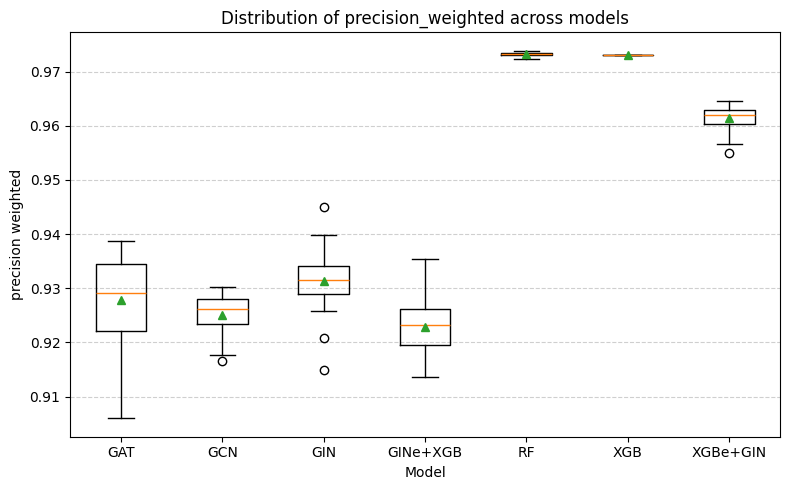

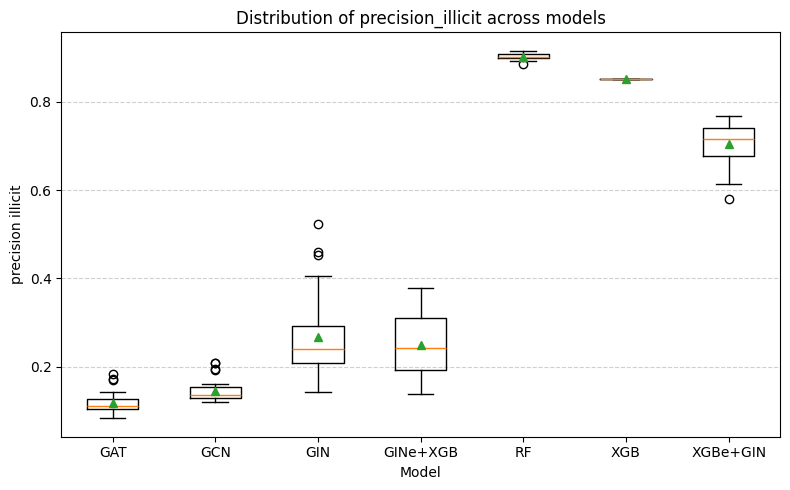

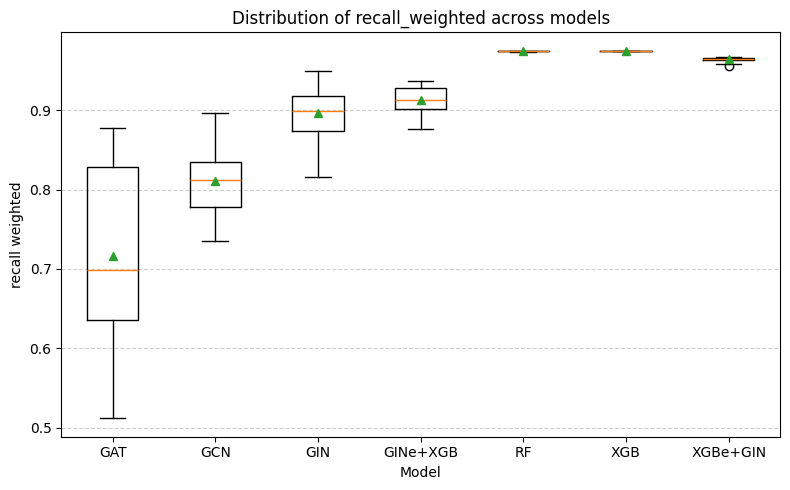

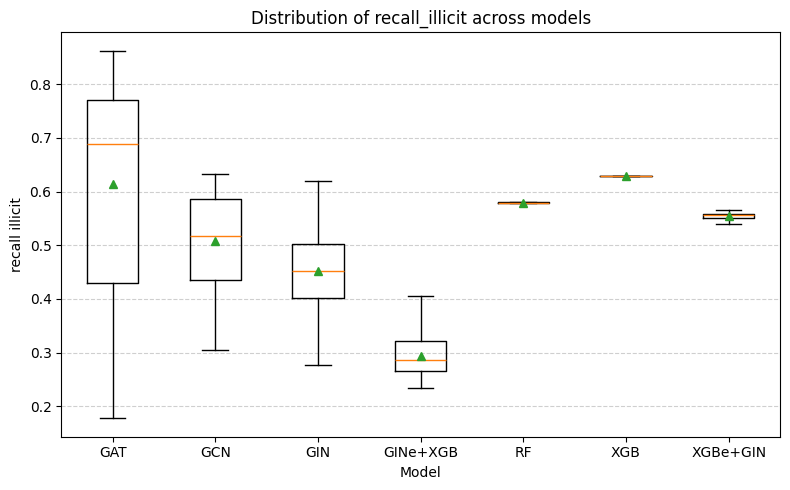

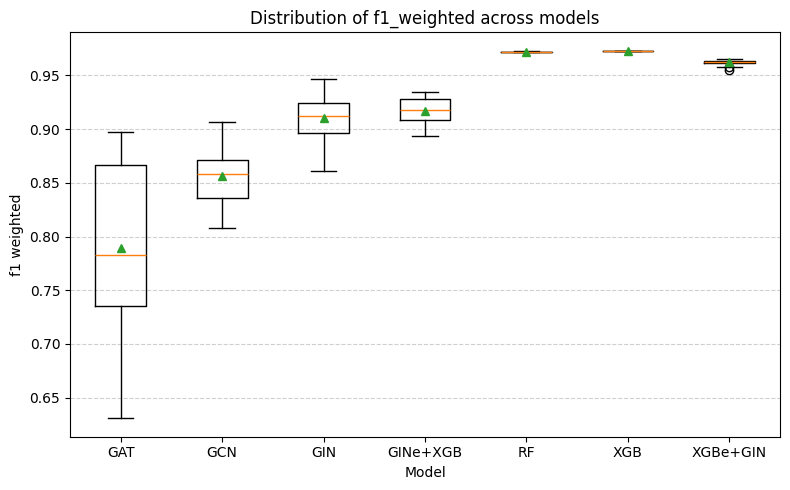

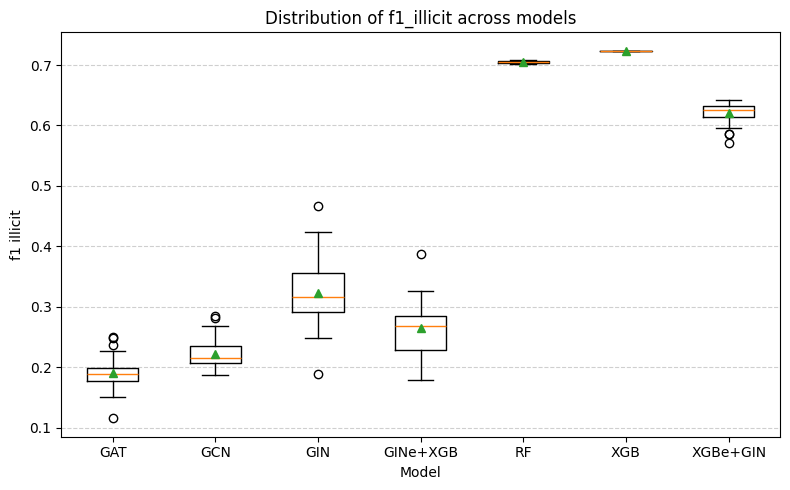

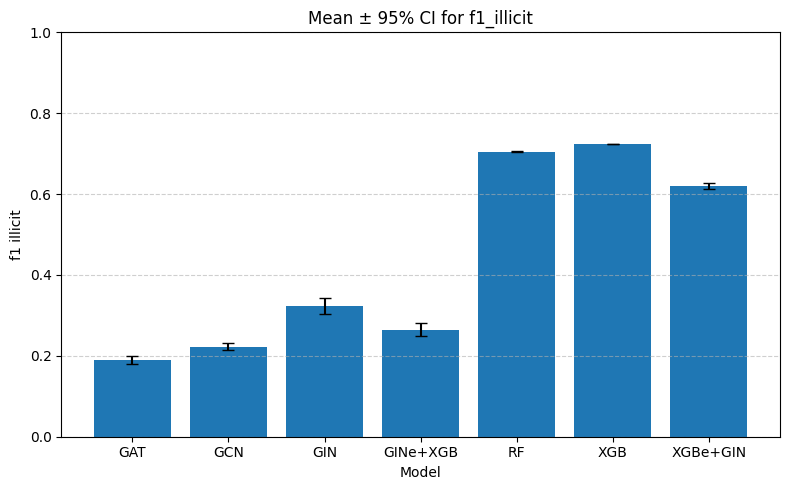

In [ ]:
df_long, df_summary, df_wide = produce_tables(testing_results)
#Boxplots by metric
boxplots_by_metric(df_long)
# Bar means with CI
bar_means_with_ci(df_summary, metric="f1_illicit")